In [308]:
# !pip install kmodes==0.12.2
!pip install xgboost
!pip install simpledbf
!pip install geopy


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from simpledbf import Dbf5
import geopy.distance
from geopy.distance import geodesic as GD

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from kmodes.kprototypes import KPrototypes

<img src="image-20231010-120042.png" width="" align="" />

# TEM QUE VER

- [x] Distribuição dos clusters muito desigual

- [x] Cluster final vai estar muito grande por falta de caracterização (todos são muito parecidos, independente das variáveis escolhidas)

- [ ] Separar entre perguntas (hipóteses) gerais e específicas

- [x] Limpar o código

- [x] Normalizar população também?

- [x] Rodar otimizacão por score antes de excluir dados correlacionados

- [ ] Ver clusters de cidades que fazem xilogravura

- [ ] Ver se já é aplicado agricultura nas localidades

- [ ] Não se limitar apenas à uma cidade, escolher uma cidade principal e outras proximas

- [x] EXCLUIR GUAMARÉ PELO AMOR DE DEUS

# Perguntas

- [ ] Faz sentido clusterizar com dados antigos e analisar com dados atuais?

# Importação dos dados

Foi realizada uma análise preliminar nos dados ofertados, selecionando-se apenas as variáveis mais relevantes de cada conjunto de dados segundo a equipe.

In [4]:
# Carregando os datasets municipios gerais
original_municipios_df = pd.read_csv('./Data/municipios.csv')
municipios_df = original_municipios_df.copy()
original_municipios_df

codigo_ibge                 nome  latitude  longitude  codigo_uf
0         5200050      Abadia de Goiás -16.75730   -49.4412         52
1         3100104  Abadia dos Dourados -18.48310   -47.3916         31
2         5200100            Abadiânia -16.19700   -48.7057         52
3         3100203               Abaeté -19.15510   -45.4444         31
4         1500107           Abaetetuba  -1.72183   -48.8788         15
...           ...                  ...       ...        ...        ...
5565      2933604          Xique-Xique -10.82300   -42.7245         29
5566      2517407               Zabelê  -8.07901   -37.1057         25
5567      3557154             Zacarias -21.05060   -50.0552         35
5568      2114007              Zé Doca  -3.27014   -45.6553         21
5569      4219853               Zortéa -27.45210   -51.5520         42

[5570 rows x 5 columns]

In [5]:
# Dataset de municipios apenas do semiárido
original_municipios_semiarido_df = pd.read_csv('./Data/municipios_semiarido.csv')
municipios_semiarido_df = original_municipios_semiarido_df.copy()
mask = municipios_semiarido_df['Município'].isin(['GUAMARÉ', 'PAULISTA'])
municipios_semiarido_df = municipios_semiarido_df[~mask]
original_municipios_semiarido_df

Cod IBGE  UF             Município  População Estimada - 2017
0      2700102  AL           ÁGUA BRANCA                      20467
1      2700300  AL             ARAPIRACA                     234185
2      2700706  AL               BATALHA                      18757
3      2700904  AL            BELO MONTE                       6797
4      2701209  AL           CACIMBINHAS                      10897
...        ...  ..                   ...                        ...
1257   2806008  SE          RIBEIRÓPOLIS                      18641
1258   2807006  SE  SÃO MIGUEL DO ALEIXO                       3943
1259   2807105  SE            SIMÃO DIAS                      40838
1260   2807303  SE                 TELHA                       3221
1261   2807402  SE        TOBIAS BARRETO                      52156

[1262 rows x 4 columns]

In [6]:
# Dataset de dados administrativos
original_administrativos_df = pd.read_csv('./Data/administrativos_total_filtrado.csv')
administrativos_total_df = original_administrativos_df.copy()
# Filtra apenas no ano de 2017
mask = administrativos_total_df['ANO'].isin([2013])
administrativos_total_df = administrativos_total_df[mask].reset_index(drop=True, inplace=False)
administrativos_total_df

ANO    IBGE7                        NOME  TTREVA_EF_TOTAL  \
0     2013  1100015  Alta Floresta D&apos;Oeste              3.4   
1     2013  1100023                   Ariquemes              3.0   
2     2013  1100031                      Cabixi              1.5   
3     2013  1100049                      Cacoal              2.4   
4     2013  1100056                  Cerejeiras              2.5   
...    ...      ...                         ...              ...   
5565  2013  5222005                  Vianópolis              2.9   
5566  2013  5222054              Vicentinópolis              4.6   
5567  2013  5222203                    Vila Boa              3.4   
5568  2013  5222302               Vila Propício              NaN   
5569  2013  5300108                    Brasília              NaN   

      TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  TXCOBPLP  PINTERDRSAI  \
0                 9.2    18.32         4.35     12.55        11.12   
1                 9.1    11.49         4.71      7.97         2.59   
2                 6.9    13.51         3.54      3.48         7.64   
3                 9.3    15.19         4.41      8.68         3.68   
4                 8.5    11.07         5.60      3.49        15.28   
...               ...      ...          ...       ...          ...   
5565             13.1    18.29         4.46      6.19        15.19   
5566             13.3    27.78         6.43      6.30         7.16   
5567             10.2    13.33         4.38      0.67         6.63   
5568              NaN     0.00         4.40      0.90         4.76   
5569              NaN    12.73         4.09     29.63         1.05   

      REN_PIBPC_D  REN_PVAAGR  REN_PVAIND  POP_TOT  
0           11.10       34.16        6.27    25728  
1           14.88        5.79       22.04   101269  
2           12.42       41.45        3.70     6495  
3           13.97       11.02       10.99    85863  
4           16.39       15.17        6.68    18041  
...           ...         ...         ...      ...  
5565        18.47       36.72       10.18    13227  
5566        27.37       44.75       14.24     7933  
5567        16.47       38.11       13.20     5246  
5568        21.92       59.97       10.22     5460  
5569        52.77        0.41        6.43  2789761  

[5570 rows x 13 columns]

In [7]:
# Dataset de dados do censo
censo_df = pd.read_csv('./Data/censo.csv',delimiter=';')
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPCT", "RIND", "RMPOB", "RPOB", #"RDPC1", "RDPC10", "RDPC2", "RDPC3", "RDPC4", "RDPC5", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_TRANSF", "P_EXTR",
        "REN0", "REN1", "RENOCUP", #"REN2", "REN3", "REN5",  
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ", 
        "IDHM", "IDHM_E", "IDHM_L", "IDHM_R", "PEA18M",] #"PEA", "PEA1014", "PEA1517",  ]
# NÃO APAGAR "HOMEM0A4", "HOMEM10A14", "HOMEM15A19", "HOMEM20A24", "HOMEM25A29", "HOMEM30A34", "HOMEM35A39", "HOMEM40A44", "HOMEM45A49", "HOMEM50A54", "HOMEM55A59", "HOMEM5A9", "HOMEM60A64", "HOMEM65A69", "HOMEM70A74", "HOMEM75A79", "HOMEMTOT", "HOMENS80", "MULH0A4", "MULH10A14", "MULH15A19", "MULH20A24", "MULH25A29", "MULH30A34", "MULH35A39", "MULH40A44", "MULH45A49", "MULH50A54", "MULH55A59", "MULH5A9", "MULH60A64", "MULH65A69", "MULH70A74", "MULH75A79", "MULHER80", "MULHERTOT",
censo_df = censo_df[mask]
censo_df = censo_df[censo_df["ANO"] == 2010]
censo_df

ANO  Codmun7  MORT1  MORT5  SOBRE40  SOBRE60  E_ANOSESTUDO  \
11130  2010  1100015  23.80  25.49    94.50    83.18          8.67   
11131  2010  1100023  19.20  20.53    96.12    87.69          9.18   
11132  2010  1100031  24.80  26.58    94.27    82.57         10.09   
11133  2010  1100049  14.30  15.38    96.41    88.56          9.74   
11134  2010  1100056  18.10  19.42    95.78    86.72         10.22   
...     ...      ...    ...    ...      ...      ...           ...   
16690  2010  5222005  14.40  17.04    93.03    82.02         10.11   
16691  2010  5222054  15.70  18.51    92.47    80.75         10.07   
16692  2010  5222203  14.50  17.09    93.02    81.98         10.49   
16693  2010  5222302  15.90  18.80    92.36    80.50          9.46   
16694  2010  5300108  14.01  15.85    94.57    86.19          9.87   

       T_ANALF11A14  T_ANALF15A17  T_ANALF15M  ...  RENOCUP  \
11130          1.22          1.52       11.99  ...   950.08   
11131          1.55          1.09        7.90  ...  1274.11   
11132          0.62          1.06       13.63  ...   827.86   
11133          1.01          0.80        8.29  ...  1277.37   
11134          1.14          0.75       10.29  ...   926.57   
...             ...           ...         ...  ...      ...   
16690          0.66          0.74        7.97  ...  1110.12   
16691          1.22          1.32       12.68  ...  1114.20   
16692          3.60          1.56       15.88  ...   792.05   
16693          4.15          1.99       19.25  ...   666.51   
16694          1.10          0.80        3.47  ...  2581.69   

       T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
11130                  16.12            1.15         2.20    6.02  0.641   
11131                   9.67            0.16         1.40    1.42  0.702   
11132                  16.59            0.65         3.10    3.64  0.650   
11133                   9.64            0.43         1.84    1.11  0.718   
11134                  10.16            0.38         1.43    1.15  0.692   
...                      ...             ...          ...     ...    ...   
16690                   5.63            1.23         1.33    0.17  0.712   
16691                  10.47            1.55         1.25    0.30  0.684   
16692                  21.64            1.74         3.81    0.22  0.647   
16693                  11.92            0.20         4.48    2.41  0.634   
16694                   5.13            1.40         0.71    0.09  0.824   

       IDHM_E  IDHM_L  IDHM_R     PEA18M  
11130   0.526   0.763   0.657     9928.0  
11131   0.600   0.806   0.716    42801.0  
11132   0.559   0.757   0.650     2648.0  
11133   0.620   0.821   0.727    37317.0  
11134   0.602   0.799   0.688     8133.0  
...       ...     ...     ...        ...  
16690   0.622   0.818   0.710     6201.0  
16691   0.562   0.804   0.707     3663.0  
16692   0.534   0.818   0.619     1962.0  
16693   0.505   0.802   0.629     2076.0  
16694   0.742   0.873   0.863  1361053.0  

[5565 rows x 52 columns]

# Tratamento dos dados

## Merging

In [8]:
# Precisamos converter todos os nomes para lowercase para o merge funcionar
municipios_df['nome'] = municipios_df['nome'].str.upper()
# municipios_semiarido_df['Município'] = municipios_semiarido_df['Município'].str.upper()
# administrativos_total_df['NOME'] = administrativos_total_df['NOME'].str.upper()
# censo_df['Município'] = censo_df['Município'].str.upper()

# Juntando os datasets
merged_municipios_df = pd.merge(municipios_df, municipios_semiarido_df, left_on='codigo_ibge', right_on='Cod IBGE')
merged_municipios_df = pd.merge(merged_municipios_df, administrativos_total_df, left_on='codigo_ibge', right_on='IBGE7')
merged_municipios_df = pd.merge(merged_municipios_df, censo_df, left_on='codigo_ibge', right_on='Codmun7')
merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7', 'ANO_x', 'ANO_y', 'Codmun7'], axis=1, inplace=True)
# merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7'], axis=1, inplace=True)
# merged_municipios_df['População Estimada - 2017'] = merged_municipios_df['População Estimada - 2017'].astype(int)
original_merged_df = merged_municipios_df.copy()
original_merged_df

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                 2.4              5.9    17.24         5.23  ...   410.96   
1                 4.4             16.5    55.56         5.58  ...   337.76   
2                 3.5             11.5     6.90         3.74  ...   389.08   
3                 4.3             16.0    20.58         5.18  ...   513.03   
4                 3.1             10.3    17.56         5.12  ...   457.36   
...               ...              ...      ...          ...  ...      ...   
1255              4.8              8.3     7.75         6.31  ...   428.36   
1256              2.2             18.5     0.00         4.36  ...   273.38   
1257              4.7              6.4    21.39         4.74  ...   492.12   
1258              6.1             11.7    17.07         5.24  ...   490.83   
1259              1.1             11.3     0.00         5.07  ...   297.81   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
3                     29.18            1.25         5.39    0.57  0.606   
4                     27.93            1.09         5.80    4.42  0.601   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  
0      0.612   0.748   0.540   3481.0  
1      0.510   0.746   0.577   3455.0  
2      0.460   0.776   0.533   6123.0  
3      0.562   0.709   0.559   5181.0  
4      0.517   0.758   0.554  20898.0  
...      ...     ...     ...      ...  
1255   0.479   0.737   0.573   3768.0  
1256   0.443   0.708   0.513   1359.0  
1257   0.498   0.764   0.569   4806.0  
1258   0.479   0.741   0.563  16888.0  
1259   0.587   0.725   0.567   1014.0  

[1260 rows x 66 columns]

## Missing values

Algumas cidades não possuem todos os dados utilizados nas análises, por isso, precisaram ser excluídas para manter o projeto data driven.

In [9]:
# df_nulls = pd.DataFrame(merged_municipios_df.isnull().sum(), columns=['Number of Missing Values'])
# df_nulls['% Missing'] = merged_municipios_df.isnull().sum() * 100 / len(merged_municipios_df)
# display(df_nulls)

# Exclui municipios com dados faltando
display(merged_municipios_df.isnull().sum())
merged_municipios_df.dropna(inplace=True)
merged_municipios_df.reset_index(drop=True, inplace=True)
merged_municipios_df

codigo_ibge    0
nome           0
latitude       0
longitude      0
codigo_uf      0
              ..
IDHM           0
IDHM_E         0
IDHM_L         0
IDHM_R         0
PEA18M         0
Length: 66, dtype: int64

codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1227      2933406       WAGNER -12.28190   -41.1715         29  BA   
1228      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1229      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1230      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1231      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                 2.4              5.9    17.24         5.23  ...   410.96   
1                 4.4             16.5    55.56         5.58  ...   337.76   
2                 3.5             11.5     6.90         3.74  ...   389.08   
3                 4.3             16.0    20.58         5.18  ...   513.03   
4                 3.1             10.3    17.56         5.12  ...   457.36   
...               ...              ...      ...          ...  ...      ...   
1227              4.8              8.3     7.75         6.31  ...   428.36   
1228              2.2             18.5     0.00         4.36  ...   273.38   
1229              4.7              6.4    21.39         4.74  ...   492.12   
1230              6.1             11.7    17.07         5.24  ...   490.83   
1231              1.1             11.3     0.00         5.07  ...   297.81   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
3                     29.18            1.25         5.39    0.57  0.606   
4                     27.93            1.09         5.80    4.42  0.601   
...                     ...             ...          ...     ...    ...   
1227                  19.28            2.99         4.09    3.87  0.587   
1228                  27.82            0.17         6.97    3.21  0.544   
1229                  26.37            1.87         4.08   14.26  0.600   
1230                  18.49            3.18         6.14    4.86  0.585   
1231                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  
0      0.612   0.748   0.540   3481.0  
1      0.510   0.746   0.577   3455.0  
2      0.460   0.776   0.533   6123.0  
3      0.562   0.709   0.559   5181.0  
4      0.517   0.758   0.554  20898.0  
...      ...     ...     ...      ...  
1227   0.479   0.737   0.573   3768.0  
1228   0.443   0.708   0.513   1359.0  
1229   0.498   0.764   0.569   4806.0  
1230   0.479   0.741   0.563  16888.0  
1231   0.587   0.725   0.567   1014.0  

[1232 rows x 66 columns]

## Feature scalling

Todos esses algoritmos baseados em distância são afetados pela escala das variáveis. Como temos um problema de clusterização, e nosso dados não possuim a mesma unidade de medida, é necessário realizar uma normalização dos mesmos para que o algorítmo não seja afetado pela magnitude dos valores.

In [10]:
# Separa as colunas que não serão normalizadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]

data_to_norm = merged_municipios_df.drop(columns=_columns, inplace=False)
data_aux = merged_municipios_df[_columns]

# Normaliza os dados com z-score
scaler_mean = data_to_norm.values.mean(axis=0)
scaler_std = data_to_norm.values.std(axis=0)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_norm)

# Recria o dataframe normalizado
normalized_data = pd.DataFrame(normalized_data, columns=data_to_norm.columns)
merged_municipios_df = data_aux.join(normalized_data)
merged_municipios_df


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...   RENOCUP  \
0           -1.006413        -1.303810  0.086878  ... -0.193111   
1            0.083658         1.050971  3.153936  ... -0.690648   
2           -0.406874        -0.059775 -0.740715  ... -0.341828   
3            0.029154         0.939896  0.354205  ...  0.500656   
4           -0.624888        -0.326354  0.112490  ...  0.122269   
...               ...              ...       ...  ...       ...   
1227         0.301672        -0.770652 -0.672683  ... -0.074843   
1228        -1.115420         1.495269 -1.292978  ... -1.128237   
1229         0.247168        -1.192735  0.419036  ...  0.358531   
1230         1.010217        -0.015345  0.073272  ...  0.349763   
1231        -1.714958        -0.104205 -1.292978  ... -0.962187   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM  \
0                  1.473041       -0.170599     1.224561 -0.521455  0.929127   
1                 -1.324455        1.638504    -0.283549 -0.270456  0.288937   
2                  0.511696        0.142979     1.628218  0.760593 -0.428075   
3                  1.228472       -0.460055    -0.261123 -0.531976  0.365760   
4                  0.993309       -0.588702    -0.031263  0.046674  0.237722   
...                     ...             ...          ...       ...       ...   
1227              -0.634017        0.938984    -0.989949 -0.035990 -0.120784   
1228               0.972615       -1.328424     0.624681 -0.135187 -1.221910   
1229               0.699826        0.038453    -0.995556  1.525614  0.212115   
1230              -0.782640        1.091753     0.159353  0.112806 -0.171999   
1231              -1.320692       -1.465112    -2.273804 -0.515443  0.801089   

        IDHM_E    IDHM_L    IDHM_R    PEA18M  
0     1.949427 -0.321675 -0.592220 -0.259868  
1     0.337573 -0.389909  0.379270 -0.261246  
2    -0.452552  0.633602 -0.776015 -0.119818  
3     1.159303 -1.652238 -0.093347 -0.169752  
4     0.448190  0.019495 -0.224629  0.663395  
...        ...       ...       ...       ...  
1227 -0.152304 -0.696962  0.274244 -0.244655  
1228 -0.721194 -1.686355 -1.301145 -0.372354  
1229  0.147943  0.224198  0.169218 -0.189631  
1230 -0.152304 -0.560494  0.011679  0.450828  
1231  1.554365 -1.106366  0.116705 -0.390642  

[1232 rows x 66 columns]

In [11]:
# Plot geográfico
fig = px.scatter_mapbox(merged_municipios_df, lat='latitude', lon='longitude', 
                        hover_name='nome', size='POP_TOT', color='UF',
                        mapbox_style='stamen-toner', center=dict(lat=-12.83, lon=-36.49), zoom=4.5)
# fig.update_geos(
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showland=True, landcolor="LightGreen",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=False, lakecolor="Blue",
#     showrivers=True, rivercolor="Blue",
#     scope="south america",
#     mapbox_style="stamen-terrain"
# )

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Agrupamento de indivíduos

## Por população

### Otimização de clusters

> Aplicação do método do cotovelo:

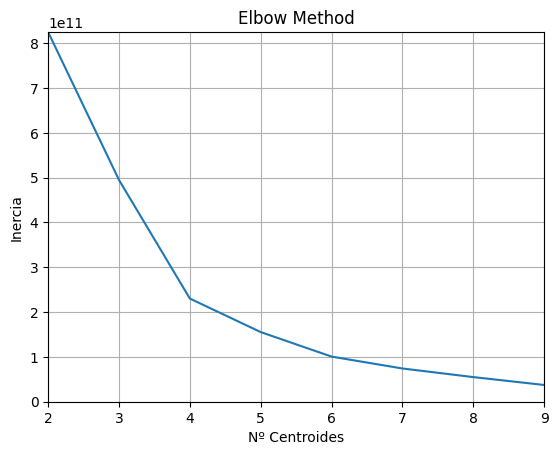

In [12]:
municipios_cluster_array = merged_municipios_df['POP_TOT'].values.reshape(-1,1)

# Determinação do número de centroides pelo método do cotovelo
centroids_max = 10
clusters_list = []
losses = []
for i in range(2,centroids_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=30)
    # kproto = KPrototypes(n_clusters=i, verbose=0, max_iter=30)
    clusters = kmeans.fit_predict(municipios_cluster_array)
    losses.append(kmeans.inertia_)

plt.plot(range(2,centroids_max), losses, color='tab:blue')
plt.xlabel('Nº Centroides')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.xlim([2,9])
plt.ylim([0, max(losses)])
plt.grid()

### Clusterização

In [13]:
n_clusters = 4

In [14]:
# n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(municipios_cluster_array)

centroids = kmeans.cluster_centers_
print(f'Silhouette Score: {silhouette_score(municipios_cluster_array, clusters)}')

Silhouette Score: 0.755494467136706


In [15]:
merged_municipios_df['cluster'] = clusters.astype(str)
merged_municipios_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_NESTUDA_NTRAB_MMEIO  \
0           -1.006413        -1.303810  0.086878  ...               1.473041   
1            0.083658         1.050971  3.153936  ...              -1.324455   
2           -0.406874        -0.059775 -0.740715  ...               0.511696   
3            0.029154         0.939896  0.354205  ...               1.228472   
4           -0.624888        -0.326354  0.112490  ...               0.993309   
...               ...              ...       ...  ...                    ...   
1227         0.301672        -0.770652 -0.672683  ...              -0.634017   
1228        -1.115420         1.495269 -1.292978  ...               0.972615   
1229         0.247168        -1.192735  0.419036  ...               0.699826   
1230         1.010217        -0.015345  0.073272  ...              -0.782640   
1231        -1.714958        -0.104205 -1.292978  ...              -1.320692   

      T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM    IDHM_E    IDHM_L  \
0          -0.170599     1.224561 -0.521455  0.929127  1.949427 -0.321675   
1           1.638504    -0.283549 -0.270456  0.288937  0.337573 -0.389909   
2           0.142979     1.628218  0.760593 -0.428075 -0.452552  0.633602   
3          -0.460055    -0.261123 -0.531976  0.365760  1.159303 -1.652238   
4          -0.588702    -0.031263  0.046674  0.237722  0.448190  0.019495   
...              ...          ...       ...       ...       ...       ...   
1227        0.938984    -0.989949 -0.035990 -0.120784 -0.152304 -0.696962   
1228       -1.328424     0.624681 -0.135187 -1.221910 -0.721194 -1.686355   
1229        0.038453    -0.995556  1.525614  0.212115  0.147943  0.224198   
1230        1.091753     0.159353  0.112806 -0.171999 -0.152304 -0.560494   
1231       -1.465112    -2.273804 -0.515443  0.801089  1.554365 -1.106366   

        IDHM_R    PEA18M  cluster  
0    -0.592220 -0.259868        0  
1     0.379270 -0.261246        0  
2    -0.776015 -0.119818        0  
3    -0.093347 -0.169752        0  
4    -0.224629  0.663395        3  
...        ...       ...      ...  
1227  0.274244 -0.244655        0  
1228 -1.301145 -0.372354        0  
1229  0.169218 -0.189631        0  
1230  0.011679  0.450828        3  
1231  0.116705 -0.390642        0  

[1232 rows x 67 columns]

In [16]:
fig = px.scatter_mapbox(
    merged_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> Através da itentificação dos clusters mais populosos, podemos reduzir o número total de municípios:

In [17]:
# Identifica clusters mais populosos
mean_pop = []
for i in range(n_clusters):
    mask = merged_municipios_df['cluster'].isin([str(i)])
    _len = merged_municipios_df[mask]['POP_TOT'].shape[0]
    _val = sum(merged_municipios_df[mask]['POP_TOT'].values)
    # Lista contendo médias de população de cada cluster
    mean_pop.append(_val / _len)

# Cria uma lista contendo os clusters mais populosos
_temp = mean_pop.copy()
_temp.sort()
highest_clusters = [str(mean_pop.index(_temp[-1])), str(mean_pop.index(_temp[-2]))]
highest_clusters
print(f'Clusters com maior população: {highest_clusters}')

# Remove clusters selecionados
mask = merged_municipios_df['cluster'].isin(highest_clusters)
lowPop_municipios_df = merged_municipios_df[~mask]
lowPop_municipios_df

Clusters com maior população: ['2', '1']


codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL   TXMOINF  ...  T_NESTUDA_NTRAB_MMEIO  \
0           -1.006413        -1.303810  0.086878  ...               1.473041   
1            0.083658         1.050971  3.153936  ...              -1.324455   
2           -0.406874        -0.059775 -0.740715  ...               0.511696   
3            0.029154         0.939896  0.354205  ...               1.228472   
4           -0.624888        -0.326354  0.112490  ...               0.993309   
...               ...              ...       ...  ...                    ...   
1227         0.301672        -0.770652 -0.672683  ...              -0.634017   
1228        -1.115420         1.495269 -1.292978  ...               0.972615   
1229         0.247168        -1.192735  0.419036  ...               0.699826   
1230         1.010217        -0.015345  0.073272  ...              -0.782640   
1231        -1.714958        -0.104205 -1.292978  ...              -1.320692   

      T_OCUPDESLOC_1  T_RMAXIDOSO    T_SLUZ      IDHM    IDHM_E    IDHM_L  \
0          -0.170599     1.224561 -0.521455  0.929127  1.949427 -0.321675   
1           1.638504    -0.283549 -0.270456  0.288937  0.337573 -0.389909   
2           0.142979     1.628218  0.760593 -0.428075 -0.452552  0.633602   
3          -0.460055    -0.261123 -0.531976  0.365760  1.159303 -1.652238   
4          -0.588702    -0.031263  0.046674  0.237722  0.448190  0.019495   
...              ...          ...       ...       ...       ...       ...   
1227        0.938984    -0.989949 -0.035990 -0.120784 -0.152304 -0.696962   
1228       -1.328424     0.624681 -0.135187 -1.221910 -0.721194 -1.686355   
1229        0.038453    -0.995556  1.525614  0.212115  0.147943  0.224198   
1230        1.091753     0.159353  0.112806 -0.171999 -0.152304 -0.560494   
1231       -1.465112    -2.273804 -0.515443  0.801089  1.554365 -1.106366   

        IDHM_R    PEA18M  cluster  
0    -0.592220 -0.259868        0  
1     0.379270 -0.261246        0  
2    -0.776015 -0.119818        0  
3    -0.093347 -0.169752        0  
4    -0.224629  0.663395        3  
...        ...       ...      ...  
1227  0.274244 -0.244655        0  
1228 -1.301145 -0.372354        0  
1229  0.169218 -0.189631        0  
1230  0.011679  0.450828        3  
1231  0.116705 -0.390642        0  

[1220 rows x 67 columns]

In [18]:
fig = px.scatter_mapbox(
    lowPop_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Por caracteristicas

Após a clusterização por população, realizou-se um agrupamento com base em indicadores socioeconômicos, a fim de identificar cidades com caracteristicas semelhantes àquelas ajudadas pela ONG.


### Otimização de features : Análise por score

Foi implementado um algorítmo para avaliar as melhores features na clusterização de um determinado modelo. Nele, utilizamos o score do silhouette para determinar o quanto uma variável influencia positivamente a formação dos clusters.

Silhouette score é uma métrica usada para calcular a qualidade de uma técnica de agrupamento (clustering). Seu valor varia de -1 a 1.

- 1: Significa que os clusters estão bem separados uns dos outros e claramente distintos. 

- 0: Significa que os clusters são indiferentes, ou podemos dizer que a distância entre os clusters não é significativa. 

- -1: significa que os clusters foram atribuídos de maneira errada.

O algorítmo apresenta a seguinte lógica:

1. Executar clusterização em cada um das variáveis individualmente para algum k.
2. Para cada cluster, é medido uma métrica de desempenho, como o coeficiente de silhueta implementado aqui.
3. A variável que oferece o melhor desempenho é salva numa lista.
4. O passo 2 e 3 são repetidos, porém, cada iteração as variáveis já escolhidas e salvas na lista são treinadas juntamente com as novas candidatas em busca de uma melhor performance. 
5. O critério de parada pode ser um número de variáveis desejada ou um ponto em que a métrica de desempenho não melhore significativamente. (ainda não implementado)

> Algoritmos utilizados nos processos de otimização:

In [19]:
# Função auxiliar para escolha de melhor variável
def find_best_feature(cluster_model, data_df, features_selected):
    # Setar variaveis de melhor candidato e score
    best_feature_candidate = None
    best_score = -1

    for feature_candidate in data_df.columns:
        # Verifique se a variável já foi selecionada.
        if feature_candidate not in features_selected:
            # Copia as variáveis selecionadas até agora e adiciona nova característica candidata.
            selected_features = features_selected + [feature_candidate]
            # Transformar o DataFrame em uma matriz numpy para treinar modelo
            current_data = data_df[selected_features].values

            # Executar o modelo de cluster
            clusters = cluster_model.fit_predict(current_data)
            # Calcular o índice de melhor desempenho.
            score = silhouette_score(current_data, clusters)

            # Se o valor do score for melhor do que o melhor até agora, atualize
            if score > best_score:
                best_score = score
                best_feature_candidate = feature_candidate

    return best_score, best_feature_candidate

# Plot das pontuações
def plot_scores(performance_scores):
    # Plota a curva de desempenho
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(performance_scores) + 1), performance_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de características')
    plt.ylabel('Pontuação de desempenho')
    plt.title('Curva de desempenho em relação ao número de características')
    plt.grid(True)
    plt.show()

# Função acha os melhores features de um dataset para se realizar um cluster
def cluster_feature_optimizer(cluster_model, data_df, desired_num_features=5):
    features_selected = []    # Lista com índices dos melhores features
    remaining_features = data_df.columns.tolist()    # Lista com nomes das colunas que não foram selecionadas
    performance_scores = []  # Lista dos resultados do desempenho

    while len(features_selected) < desired_num_features and remaining_features:
        best_score, best_feature_candidate = find_best_feature(cluster_model, data_df, features_selected)

        features_selected.append(best_feature_candidate)        # Salvar a melhor variável ao array
        remaining_features.remove(best_feature_candidate)       # Remove variável para
        performance_scores.append(best_score)                   # Armazena o resultado do desempenho
        print(best_feature_candidate)

    plot_scores(performance_scores)

    return features_selected

# Algoritmos implementados a partir do artigo: https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf

# Função para calcular a entropia de uma feature
def calculate_entropy(data, feature_index):
    feature_values = data[:, feature_index]
    unique_values, counts = np.unique(feature_values, return_counts=True)
    total_count = len(feature_values)
    probabilities = counts / total_count
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Função para classificar características com base na entropia
def rank_features(data):
    num_features = data.shape[1]
    feature_entropies = []

    for feature_index in range(num_features):
        entropy = calculate_entropy(data, feature_index)
        feature_entropies.append(entropy)

    # Classificação de características com base na entropia (ordem crescente)
    ranked_features = np.argsort(feature_entropies)

    return ranked_features


> Preparação do dataframe para a otimização:

In [20]:
data = lowPop_municipios_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

> Verificação inicial dos scores, considerando todas as variáveis do dataframe:

In [21]:
n_clusters = 5

In [22]:
data_array = data.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (All Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (All Features): 0.09631454636976365


> Método 1: Seleção de features com base na entropia.

In [23]:
n_features = 10

In [24]:
# Gera lista de colunas com base na entropia
ranked_features = rank_features(data.values)
selected_columns = data.iloc[:, ranked_features[:n_features]]
print("Classificação de características com base na entropia: \n", selected_columns.columns)

# Clusteriza novamente considerando apenas colunas selecionadas
data_array = selected_columns.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data, clusters)}')

Classificação de características com base na entropia: 
 Index(['GINI', 'P_EXTR', 'THEIL', 'TTREVA_EF_TOTAL', 'IDHM_L', 'EMP', 'IDHM_R',
       'IDHM', 'TTREVA_EM_TOTAL', 'MORT1'],
      dtype='object')
Silhouette Score (Selected Features): 0.08875245134901066


Inferência: O primeiro método utilizado não apresentou melhora no Silhouette Score, por isso, foi descartado.

> Método 2: Seleção de features com base no Silhouette Score (Unsupervised Feature Selection).

In [25]:
n_features = 8

P_EXTR
REN_PVAIND
PEA18M
REN_PIBPC_D
TXCOBPLP
P_TRANSF
RDPCT
RENOCUP


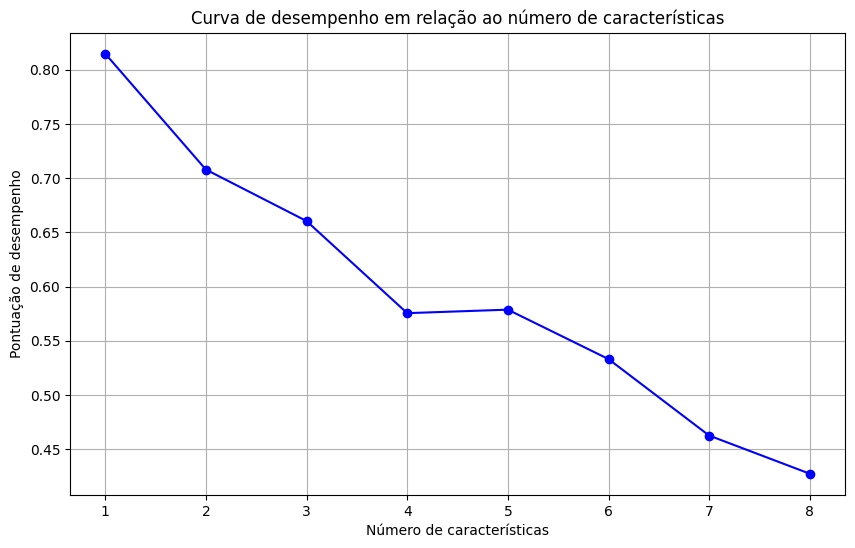

Number of selected features: 8


In [26]:
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
features_selected = cluster_feature_optimizer(kmeans, data, n_features)

print(f'Number of selected features: {len(features_selected)}')


In [27]:
data_array = data[features_selected].values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score (Selected Features): {silhouette_score(data_array, clusters)}')

Silhouette Score (Selected Features): 0.4102657584991373


Inferência: O modelo clusterizado a partir das features selecionadas pelo método 2 apresentaram melhoria significativa no Silhouette Score, portanto, foi utilizado no agrupamento final.

> Criação do dataframe reduzido:

In [28]:
# Gera o dataframe com as features selecionadas
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]
_columns.extend(features_selected)

reduced_lowPop_df = lowPop_municipios_df[_columns]

reduced_lowPop_df['cluster'] = clusters.astype(str)
# Dataframe apenas com variáveis selecionadas pela otimização
reduced_lowPop_df

/tmp/ipykernel_2728/821434987.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  REN_PIBPC_D  TXCOBPLP  P_TRANSF  \
0    -0.317911   -0.457492 -0.259868    -0.689751 -0.151572 -0.430479   
1    -0.266632   -0.412315 -0.261246    -0.662871  2.118568 -0.694954   
2    -0.317911   -0.326481 -0.119818    -0.639352  0.186225 -0.514630   
3     2.542340    2.014766 -0.169752    -0.175682  0.095420  3.347736   
4    -0.317911    1.462489  0.663395     0.217430 -0.224216  0.045233   
...        ...         ...       ...          ...       ...       ...   
1227 -0.317911   -0.246294 -0.244655    -0.588953 -0.540219 -0.464826   
1228 -0.215352   -0.617866 -0.372354    -0.578873 -0.551116 -0.500891   
1229 -0.317911   -0.428127 -0.189631     0.200630 -0.442149 -0.533521   
1230 -0.181166   -0.466527  0.450828    -0.343678 -0.289596 -0.344610   
1231  0.701979   -0.504926 -0.390642    -0.249600 -0.340447  0.301121   

         RDPCT   RENOCUP cluster  
0    -0.656450 -0.193111       1  
1     0.240473 -0.690648       1  
2    -0.720706 -0.341828       1  
3    -0.229993  0.500656       3  
4    -0.300155  0.122269       1  
...        ...       ...     ...  
1227  0.117724 -0.074843       1  
1228 -1.140414 -1.128237       1  
1229  0.071465  0.358531       1  
1230 -0.087982  0.349763       1  
1231 -0.053252 -0.962187       1  

[1220 rows x 16 columns]

In [29]:
fig = px.scatter_mapbox(
    reduced_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    # size='POP_TOT',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Análise de correlação

Por se tratar de um longo conjunto de dados com variáveis diversas, foi preciso avaliar a existência de variáveis correlacionadas a fim de melhorar os posteriores procedimentos de otimização. Para isso, realizou-se um algoritmo que identifica exclui variáveis redundantes com base em uma tolerância positiva e negativa.

In [30]:
# Função para remoção de features correlacionadas a partir de uma tolerância
def remove_correlated(data, tolerance = 0.85):

    features = data.columns
    n_features = features.shape[0]
    correlation_matrix = data.corr().values
    correlated_features = []
    remove_features = []

    # Gera uma lista de variáveis correlacionadas 
    for row in range(n_features):
        for col in range(row, n_features):
            if(row == col):
                pass
            else:
                _val = correlation_matrix[row][col]
                if(_val >= tolerance or _val <= -tolerance):
                    correlated_features.append([features[row], features[col]])
                    # Apenas o primeiro feature do par é selecionado para remoção (pode ser alterado depois)
                    if(features[row] not in remove_features):
                        remove_features.append(features[row])

    # Remove features selecionadas
    for feature in remove_features:
        data.drop([feature], axis=1, inplace=True)

    print(f'Initial number of features: {n_features}')
    print(f'Final number of features: {data.shape[1]}')
    print('Features removed: \n', remove_features, '\n')

    return remove_features

# Plot de matrix de correlação
def plot_correlation(correlation_matrix):
    # Gera uma máscara com o triângulo superior
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Matriz de Correlação entre Features em cada Cluster")

    plt.show()

Initial number of features: 8
Final number of features: 7
Features removed: 
 ['RDPCT'] 



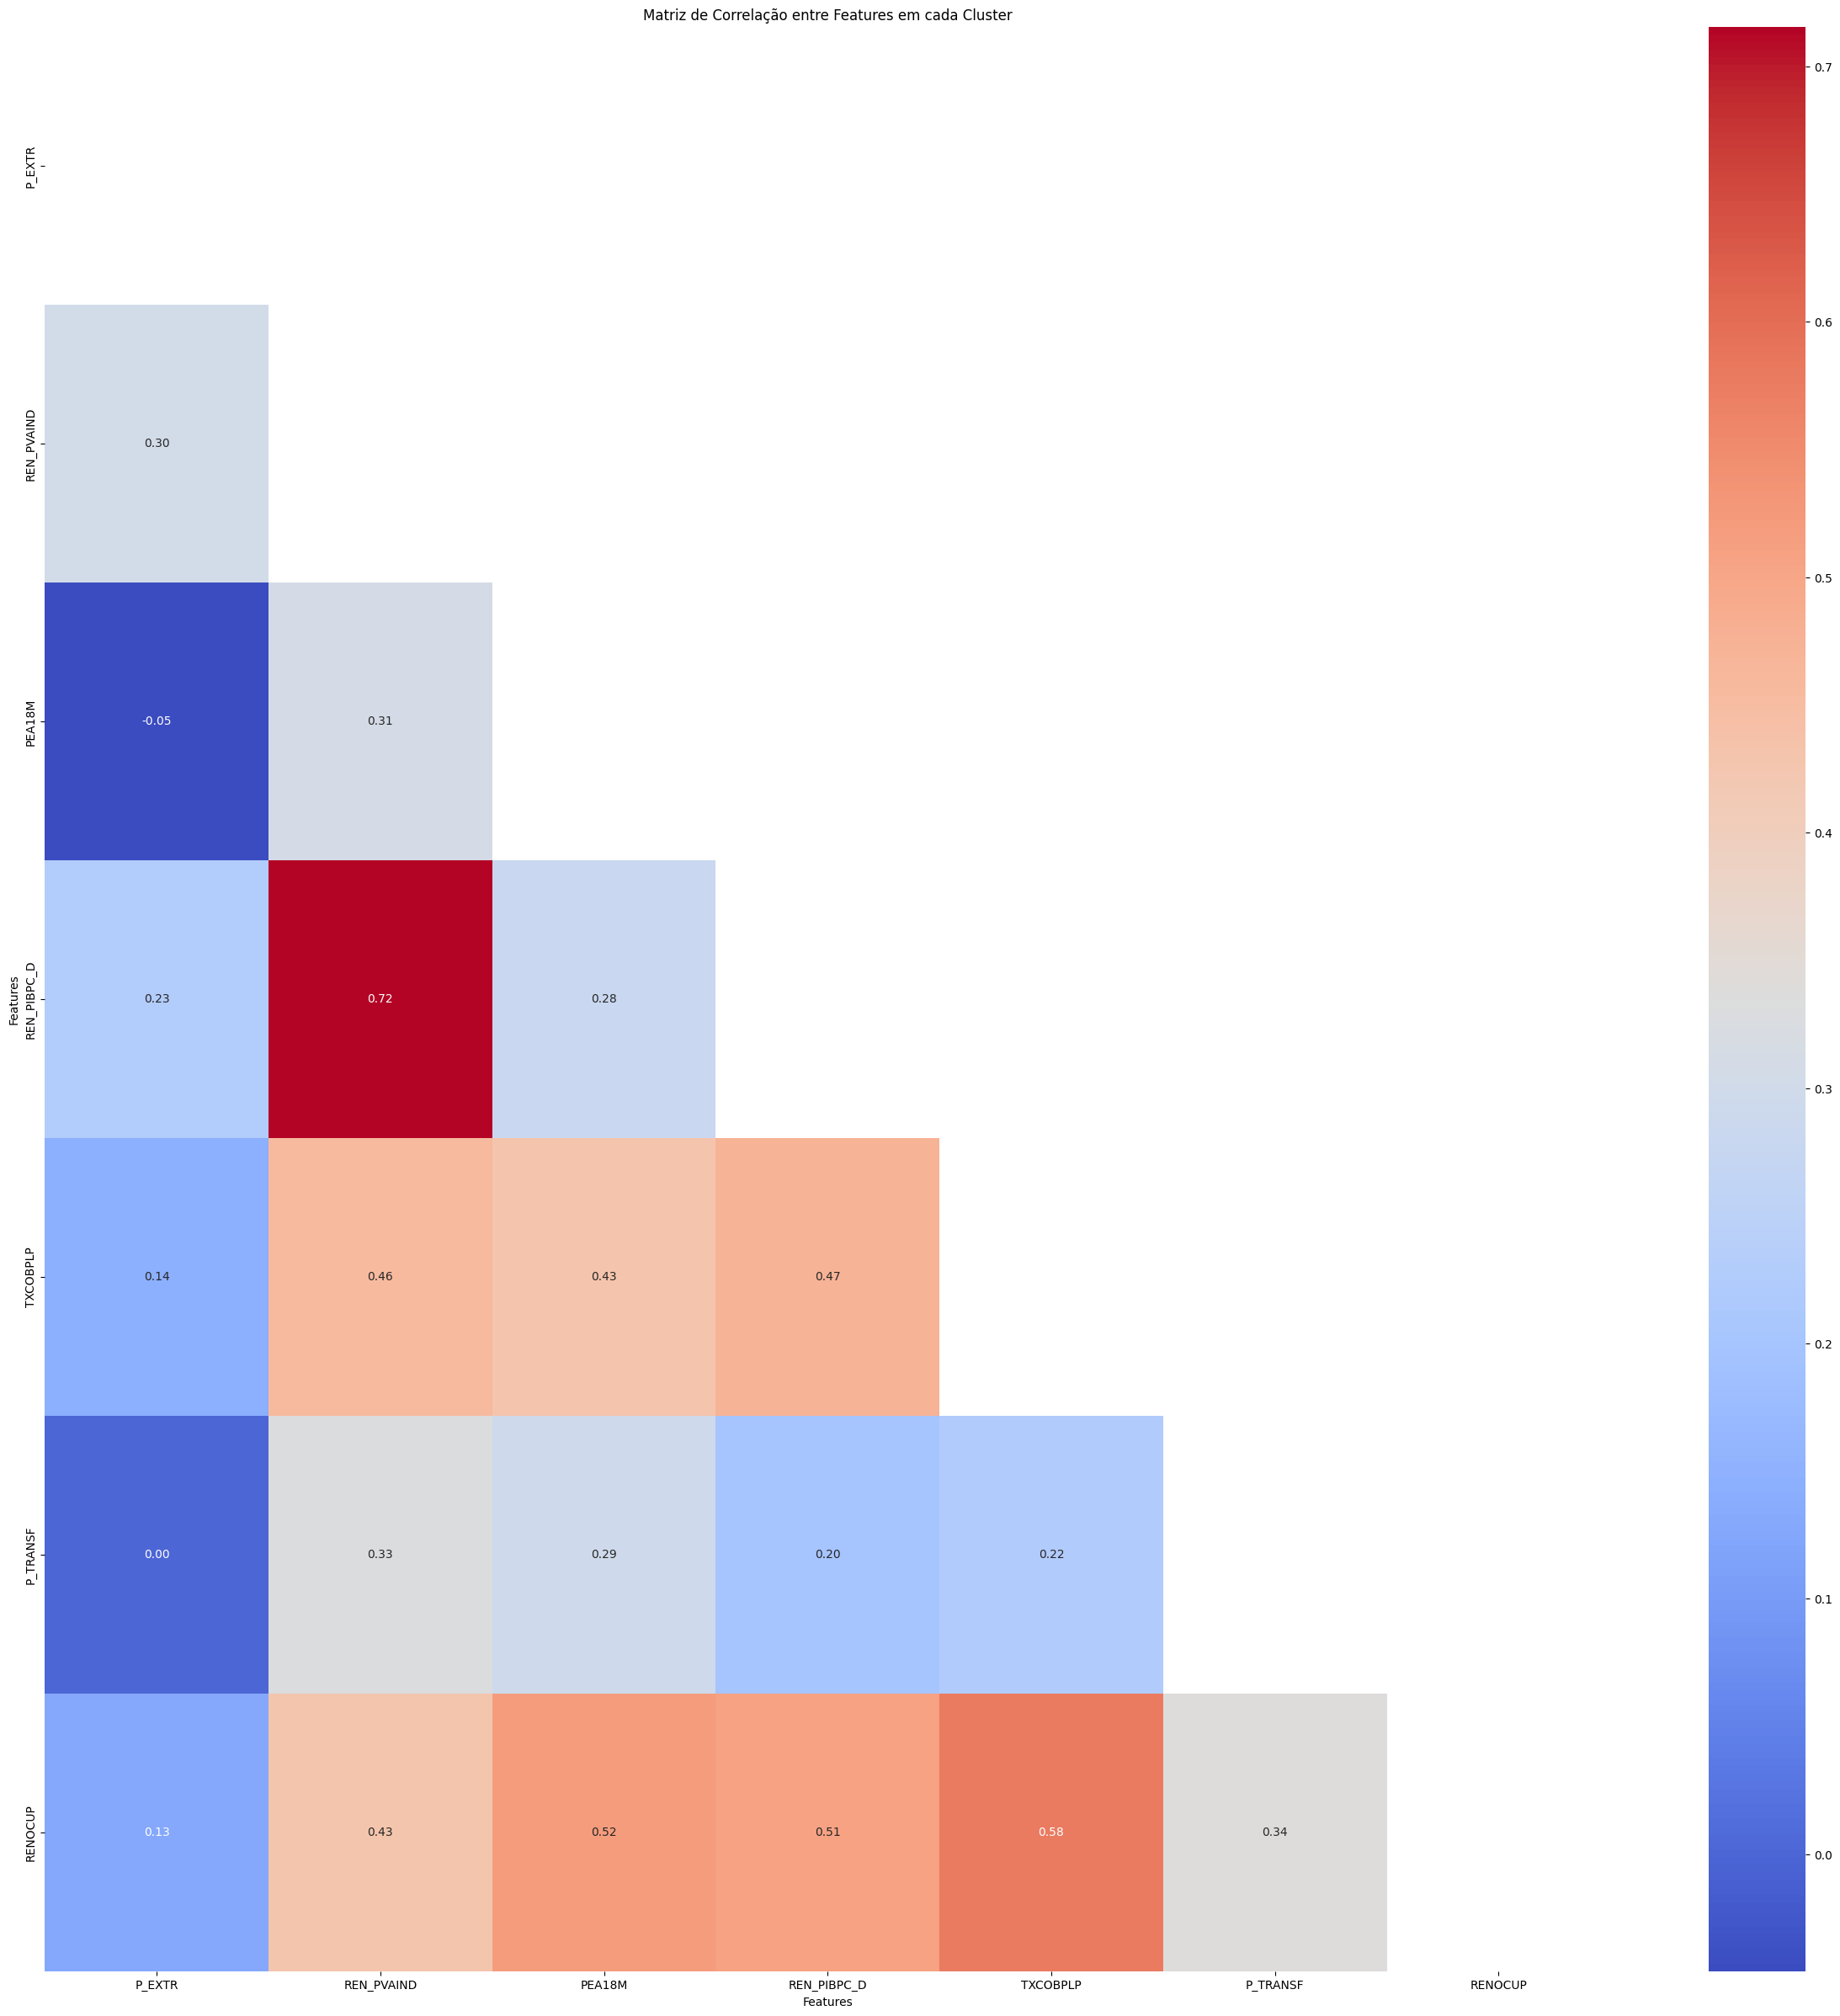

In [31]:
data = reduced_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
).copy()

remove_features = remove_correlated(data, tolerance=0.8)

plot_correlation(data.corr())

In [32]:
# Remove as features redundantes
reduced2_lowPop_df = reduced_lowPop_df.copy()
for feature in remove_features:
    reduced2_lowPop_df.drop([feature], axis=1, inplace=True)
reduced2_lowPop_df

codigo_ibge         nome  codigo_uf  UF  latitude  longitude  POP_TOT  \
0         2300101      ABAIARA         23  CE  -7.34588   -39.0416    11089   
1         2900108       ABAÍRA         29  BA -13.24880   -41.6619     9132   
2         2900207        ABARÉ         29  BA  -8.72073   -39.1162    18989   
3         2300150      ACARAPE         23  CE  -4.22083   -38.7055    16011   
4         2300200       ACARAÚ         23  CE  -2.88769   -40.1183    60137   
...           ...          ...        ...  ..       ...        ...      ...   
1227      2933406       WAGNER         29  BA -12.28190   -41.1715     9504   
1228      2211704  WALL FERRAZ         22  PI  -7.23151   -41.9050     4355   
1229      2933455    WANDERLEY         29  BA -12.11440   -43.8958    13089   
1230      2933604  XIQUE-XIQUE         29  BA -10.82300   -42.7245    48100   
1231      2517407       ZABELÊ         25  PB  -8.07901   -37.1057     2169   

        P_EXTR  REN_PVAIND    PEA18M  REN_PIBPC_D  TXCOBPLP  P_TRANSF  \
0    -0.317911   -0.457492 -0.259868    -0.689751 -0.151572 -0.430479   
1    -0.266632   -0.412315 -0.261246    -0.662871  2.118568 -0.694954   
2    -0.317911   -0.326481 -0.119818    -0.639352  0.186225 -0.514630   
3     2.542340    2.014766 -0.169752    -0.175682  0.095420  3.347736   
4    -0.317911    1.462489  0.663395     0.217430 -0.224216  0.045233   
...        ...         ...       ...          ...       ...       ...   
1227 -0.317911   -0.246294 -0.244655    -0.588953 -0.540219 -0.464826   
1228 -0.215352   -0.617866 -0.372354    -0.578873 -0.551116 -0.500891   
1229 -0.317911   -0.428127 -0.189631     0.200630 -0.442149 -0.533521   
1230 -0.181166   -0.466527  0.450828    -0.343678 -0.289596 -0.344610   
1231  0.701979   -0.504926 -0.390642    -0.249600 -0.340447  0.301121   

       RENOCUP cluster  
0    -0.193111       1  
1    -0.690648       1  
2    -0.341828       1  
3     0.500656       3  
4     0.122269       1  
...        ...     ...  
1227 -0.074843       1  
1228 -1.128237       1  
1229  0.358531       1  
1230  0.349763       1  
1231 -0.962187       1  

[1220 rows x 15 columns]

### Otimização de centroides

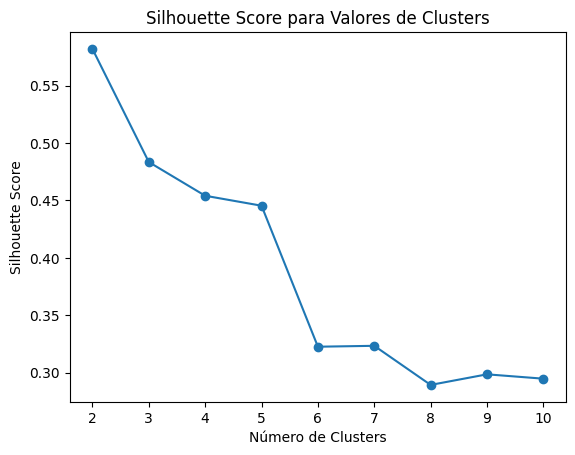

O melhor número de clusters é: 2


In [33]:
# Definer uma faixa de números de clusters para testar
min_clusters = 2
max_clusters = 10
range_n_clusters = range(min_clusters, max_clusters + 1)

# Lista para armazenar os valores do silhouette_score
silhouette_scores = []

# Executa o K-Means para diferentes números de clusters e calcula o silhouette_score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plota o gráfico do silhouette_score para cada número de clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score para Valores de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Encontre o número de clusters que maximiza o silhouette_score
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"O melhor número de clusters é: {best_n_clusters}")

O número de clusters será escolhido como 5 por ser uma boa quantidade de clusters e também conseguir distinguir eficientemente um grupo de outro. 

### Clusterização

In [34]:
n_clusters = 5

In [35]:
# Clusterização por características
data = reduced2_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100, random_state=111)
clusters = kmeans.fit_predict(data.values)
reduced2_lowPop_df['cluster'] = clusters.astype(str)

print(f'Silhouette Score: {silhouette_score(data.values, clusters)}')

Silhouette Score: 0.45982104338885793


In [36]:
fig = px.scatter_mapbox(
    reduced2_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Análise de importância com classificador

Esta análise consistiu em coverter o problema de agrupamento não supervisionado em um problema de classificação supervisionado usando um classificador. As etapas são as seguintes:

- 1: Alterar os rótulos do cluster para rótulos binários Um-vs-Todos

- 2: Treinar um classificador (RandomForest e XGBoost) para diferenciar um cluster dos demais

- 3: Imprimir as importâncias de cada variável do modelo 

In [37]:
# Essa implementacao analisa a importancia dos features para diferenciação.
def features_importance(df_original, clusters, mapa_cluster):
    # mapa_cluster = {0:1, 1:0, 2:0, 3:0}
    df = df_original.copy()
    df["cluster"] = clusters

    print(df['cluster'].value_counts())
    df['cluster'] = df['cluster'].astype(int)
    binary_cluster = df['cluster'].map(mapa_cluster)

    # Treinar classificador
    df = df.drop(columns=['cluster'])
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.values, binary_cluster.values)

    # Index sort as variáveis mais importantes
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # Salvar os features mais importantes com os nomes e pesos
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:len(df.columns)].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    return list(zip(most_important_features, most_important_weights))

# Mesmo método, porém utilizando o XGBoost
def features_importance_xgboost(df_original, n_clusters, clusters, cluster_to_map):
    mapa_cluster = {0:0, 1:0, 2:0, 3:0, 4:0}
    mapa_cluster[cluster_to_map] = 1

    df = df_original.copy()
    df['cluster'] = clusters
    binary_cluster = df['cluster'].map(mapa_cluster)
    df = df.drop(columns=['cluster'])

    # Treina o modelo xgboost
    clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
    clf.fit(df.values, binary_cluster)
    # Necessário para que apareça os nomes das features
    clf.get_booster().feature_names = df.columns.to_list()
    print("Performance do modelo xgboost: ", str(round(clf.score(df.values, binary_cluster) * 100, 2))+"%")
    feature_importance = clf.get_booster().get_score(importance_type='weight')
    # xgb.plot_importance(clf)

    feature_importance_sorted = feature_importance
    # feature_importance_sorted = dict(sorted(feature_importance.items(), key=lambda item: item[1]))
    keys = list(feature_importance_sorted.keys())
    values = list(feature_importance_sorted.values())

    plot = sns.barplot(x=keys, y=values, width=1, palette=sns.color_palette("Set2"))

    for item in plot.get_xticklabels():
        item.set_rotation(45)
    plt.title(f'Cluster {cluster_to_map}')
    plt.xlabel('Feature')
    plt.ylabel('XGBoost weight')
    plt.show()

    return feature_importance

Performance do modelo xgboost:  100.0%


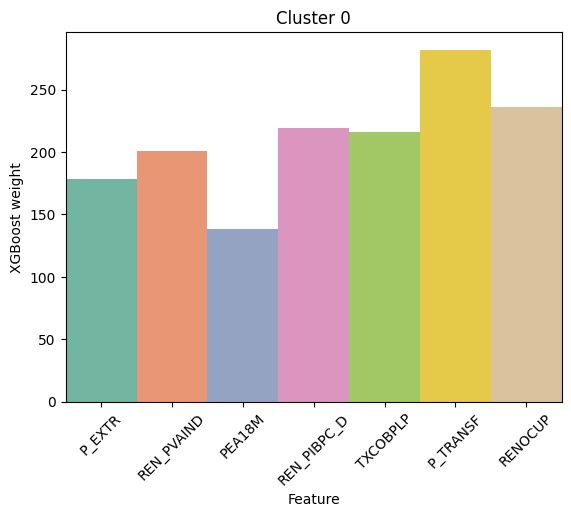

Performance do modelo xgboost:  100.0%


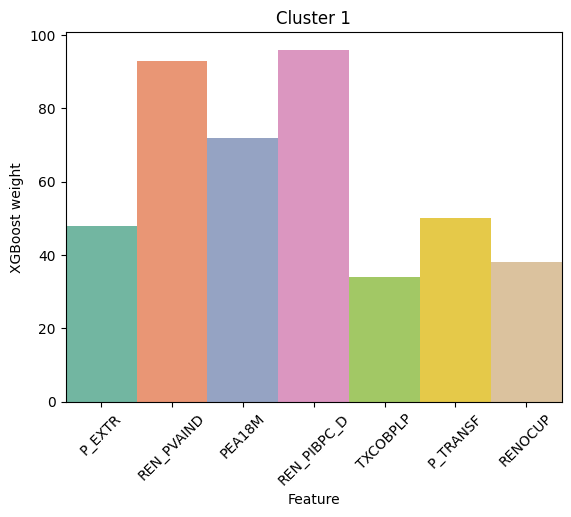

Performance do modelo xgboost:  100.0%


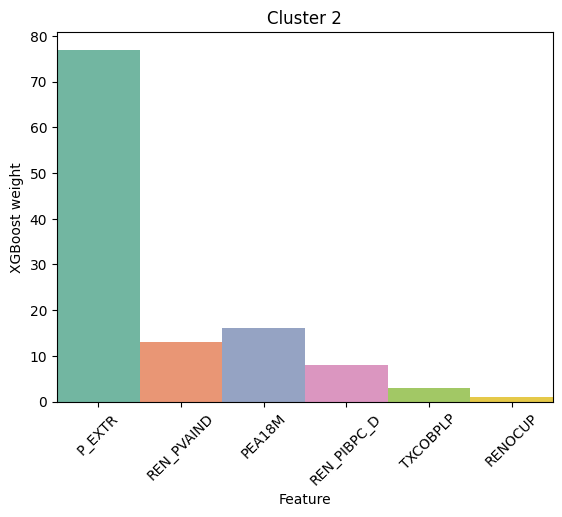

Performance do modelo xgboost:  100.0%


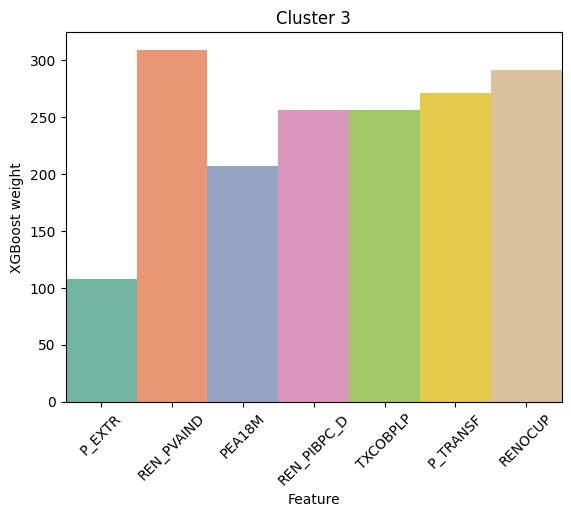

Performance do modelo xgboost:  100.0%


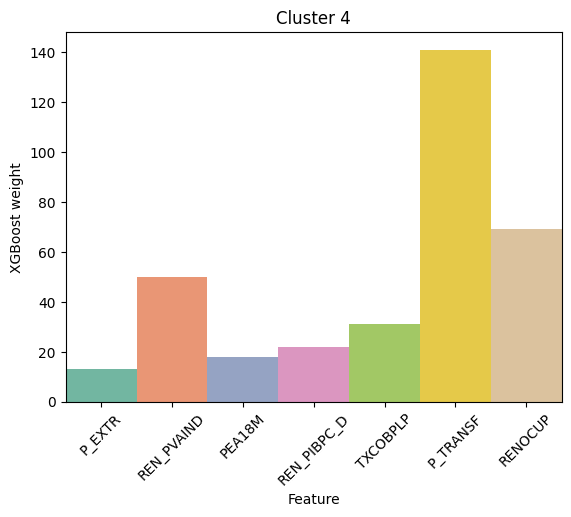

In [38]:
# important_features = features_importance(data, clusters)
# print(important_features, '\n')
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=0)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=1)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=2)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=3)
feature_importance = features_importance_xgboost(data,  n_clusters=n_clusters, clusters=clusters, cluster_to_map=4)

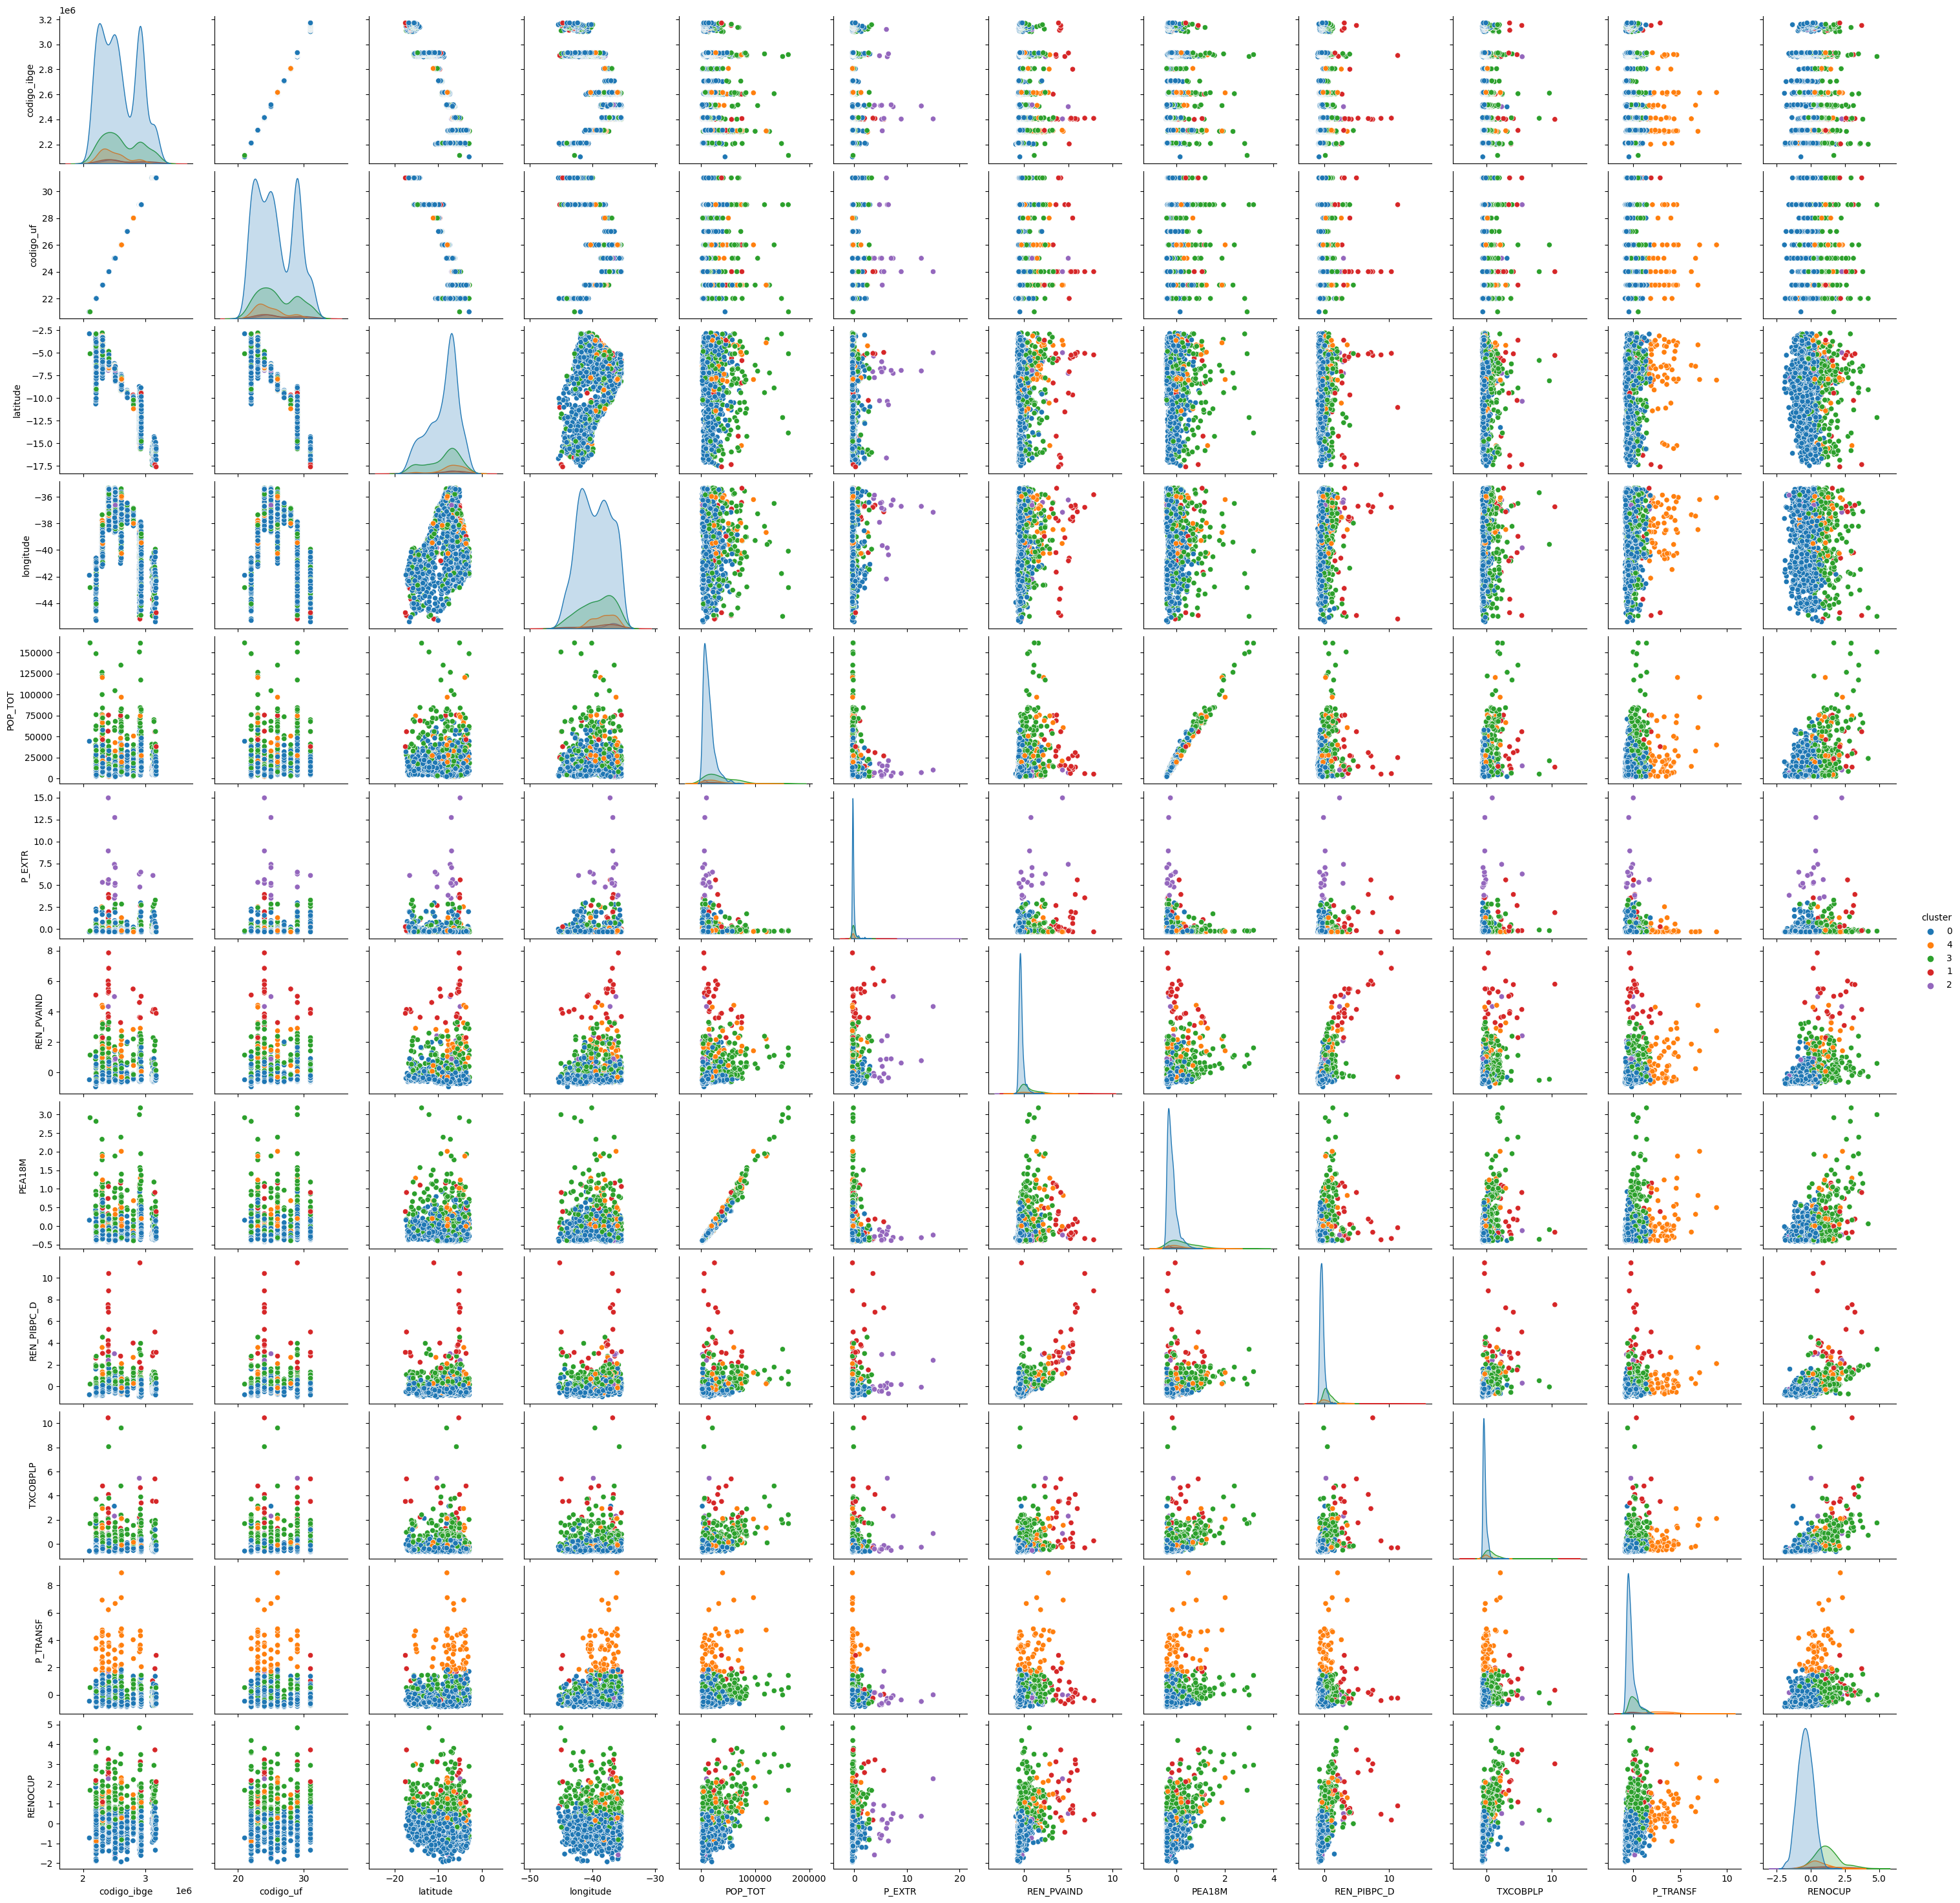

In [39]:
# Pairplot das variáveis 
sns.pairplot(data=reduced2_lowPop_df, hue='cluster')
plt.show()

Inferência: Os clusters foram separados em características bem definidas:  Cluster 0: Municípios com baixa renda per capta, Cluster 1: Municípios com mais alta renda per capta dentre os outros, Cluster 2: Municipios com mais alta taxa de extrativismo mineral, Cluster 3: Municípios com alta renda e baixa industrialização, Cluster 4:  Municípios com alta renda e alta industrialização. 

# Análise dos municípios

## Comparação com Cidades do Bem

In [70]:
# Revertendo o dataset normalizado para seus valores iniciais
_municipios = reduced2_lowPop_df['nome']
unnormalized_df = original_merged_df[original_merged_df['nome'].isin(_municipios)]
unnormalized_df['cluster'] = reduced2_lowPop_df['cluster'].astype(str).values
unnormalized_df

/tmp/ipykernel_2728/448782503.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0         2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1         2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2         2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3         2300150      ACARAPE  -4.22083   -38.7055         23  CE   
4         2300200       ACARAÚ  -2.88769   -40.1183         23  CE   
...           ...          ...       ...        ...        ...  ..   
1255      2933406       WAGNER -12.28190   -41.1715         29  BA   
1256      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
1257      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
1258      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
1259      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

      TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  \
0                 2.4              5.9    17.24         5.23  ...   
1                 4.4             16.5    55.56         5.58  ...   
2                 3.5             11.5     6.90         3.74  ...   
3                 4.3             16.0    20.58         5.18  ...   
4                 3.1             10.3    17.56         5.12  ...   
...               ...              ...      ...          ...  ...   
1255              4.8              8.3     7.75         6.31  ...   
1256              2.2             18.5     0.00         4.36  ...   
1257              4.7              6.4    21.39         4.74  ...   
1258              6.1             11.7    17.07         5.24  ...   
1259              1.1             11.3     0.00         5.07  ...   

      T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                     30.48            1.61         8.04    0.64  0.628   
1                     15.61            3.86         5.35    2.31  0.603   
2                     25.37            2.00         8.76    9.17  0.575   
3                     29.18            1.25         5.39    0.57  0.606   
4                     27.93            1.09         5.80    4.42  0.601   
...                     ...             ...          ...     ...    ...   
1255                  19.28            2.99         4.09    3.87  0.587   
1256                  27.82            0.17         6.97    3.21  0.544   
1257                  26.37            1.87         4.08   14.26  0.600   
1258                  18.49            3.18         6.14    4.86  0.585   
1259                  15.63            0.00         1.80    0.68  0.623   

      IDHM_E  IDHM_L  IDHM_R   PEA18M  cluster  
0      0.612   0.748   0.540   3481.0        0  
1      0.510   0.746   0.577   3455.0        0  
2      0.460   0.776   0.533   6123.0        0  
3      0.562   0.709   0.559   5181.0        4  
4      0.517   0.758   0.554  20898.0        3  
...      ...     ...     ...      ...      ...  
1255   0.479   0.737   0.573   3768.0        0  
1256   0.443   0.708   0.513   1359.0        0  
1257   0.498   0.764   0.569   4806.0        0  
1258   0.479   0.741   0.563  16888.0        0  
1259   0.587   0.725   0.567   1014.0        0  

[1220 rows x 67 columns]

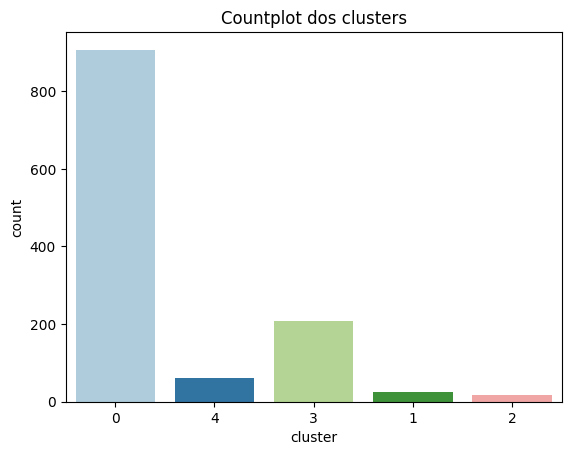

In [ ]:
# Verifica a quantidade de municípios em cada cluster
sns.countplot(data=unnormalized_df, x='cluster', palette='Paired')
plt.title('Countplot dos clusters')
plt.show()

<img src="cidades do bem.png" width="75%" align="" />

<img src="cidades do bem 2.png" width="75%" align="" />

In [41]:
municipios_do_bem = [
                    'INAJÁ',
                    'BUÍQUE',
                    'SÃO JOSÉ DA TAPERA',
                    'MAURITI'
                    ]
                    
mask = unnormalized_df['nome'].isin(municipios_do_bem)
municipios_do_bem_df = unnormalized_df[mask]

municipios_do_bem_df[['nome', 'UF', 'cluster']]

nome  UF cluster
185               BUÍQUE  PE       0
486                INAJÁ  PE       0
695              MAURITI  CE       0
1067  SÃO JOSÉ DA TAPERA  AL       0

> Como todas as cidades do bem se localizam no cluster 0, podemos descartar os demais clusters para manter um número reduzido de municípios semelhantes:

In [72]:
# Filtra os municípios pertencentes aos mesmos clusters dos municípios do bem
clusters_do_bem = municipios_do_bem_df['cluster'].unique()
mask = unnormalized_df['cluster'].isin(clusters_do_bem)
unnormalized_df = unnormalized_df[mask]
unnormalized_df.drop(columns=['cluster'], inplace=True)
unnormalized_df.reset_index(drop=True, inplace=True)
unnormalized_df

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



codigo_ibge         nome  latitude  longitude  codigo_uf  UF  \
0        2300101      ABAIARA  -7.34588   -39.0416         23  CE   
1        2900108       ABAÍRA -13.24880   -41.6619         29  BA   
2        2900207        ABARÉ  -8.72073   -39.1162         29  BA   
3        2200053        ACAUÃ  -8.21954   -41.0831         22  PI   
4        2300309     ACOPIARA  -6.08911   -39.4480         23  CE   
..           ...          ...       ...        ...        ...  ..   
902      2933406       WAGNER -12.28190   -41.1715         29  BA   
903      2211704  WALL FERRAZ  -7.23151   -41.9050         22  PI   
904      2933455    WANDERLEY -12.11440   -43.8958         29  BA   
905      2933604  XIQUE-XIQUE -10.82300   -42.7245         29  BA   
906      2517407       ZABELÊ  -8.07901   -37.1057         25  PB   

     TTREVA_EF_TOTAL  TTREVA_EM_TOTAL  TXMOINF  TXBRUTAMORT  ...  RENOCUP  \
0                2.4              5.9    17.24         5.23  ...   410.96   
1                4.4             16.5    55.56         5.58  ...   337.76   
2                3.5             11.5     6.90         3.74  ...   389.08   
3                5.2             14.6    25.00         5.37  ...   225.42   
4                3.2             13.7    17.30         6.68  ...   398.32   
..               ...              ...      ...          ...  ...      ...   
902              4.8              8.3     7.75         6.31  ...   428.36   
903              2.2             18.5     0.00         4.36  ...   273.38   
904              4.7              6.4    21.39         4.74  ...   492.12   
905              6.1             11.7    17.07         5.24  ...   490.83   
906              1.1             11.3     0.00         5.07  ...   297.81   

     T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
0                    30.48            1.61         8.04    0.64  0.628   
1                    15.61            3.86         5.35    2.31  0.603   
2                    25.37            2.00         8.76    9.17  0.575   
3                    20.77            0.50         3.92    1.01  0.528   
4                    24.61            1.05         7.28    1.60  0.595   
..                     ...             ...          ...     ...    ...   
902                  19.28            2.99         4.09    3.87  0.587   
903                  27.82            0.17         6.97    3.21  0.544   
904                  26.37            1.87         4.08   14.26  0.600   
905                  18.49            3.18         6.14    4.86  0.585   
906                  15.63            0.00         1.80    0.68  0.623   

     IDHM_E  IDHM_L  IDHM_R   PEA18M  
0     0.612   0.748   0.540   3481.0  
1     0.510   0.746   0.577   3455.0  
2     0.460   0.776   0.533   6123.0  
3     0.411   0.692   0.517   2815.0  
4     0.517   0.724   0.563  19055.0  
..      ...     ...     ...      ...  
902   0.479   0.737   0.573   3768.0  
903   0.443   0.708   0.513   1359.0  
904   0.498   0.764   0.569   4806.0  
905   0.479   0.741   0.563  16888.0  
906   0.587   0.725   0.567   1014.0  

[907 rows x 66 columns]

## Impacto

### Povoados, vilas, lugarejos e aldeias próximas

In [359]:
# Carrega dados de povoados
original_localidades_df = Dbf5(
    "./Data/BR_Localidades_2010_v1.dbf", codec="latin-1"
).to_dataframe()

localidades_df = original_localidades_df.copy().drop(
    columns=[
        "CD_CATEGOR",
        "CD_NIVEL",
        "NM_MICRO",
        "NM_BAIRRO",
        "NM_SUBDIST",
        "CD_GEOCODB",
        "CD_GEOCODD",
        "CD_GEOCODI",
        "NM_MESO",
        "NM_DISTRIT",
        "ALT",
        "GMRotation",
        "ID",
    ]
)

original_localidades_df


ID       CD_GEOCODI    TIPO    CD_GEOCODB NM_BAIRRO   CD_GEOCODS  \
0          1  110001505000001  URBANO  110001505006   Redondo  11000150500   
1          2  110001515000001  URBANO           NaN       NaN  11000151500   
2          3  110001520000001  URBANO           NaN       NaN  11000152000   
3          4  110001525000001  URBANO           NaN       NaN  11000152500   
4          5  110001530000001  URBANO           NaN       NaN  11000153000   
...      ...              ...     ...           ...       ...          ...   
21881  21882  530010805180237  URBANO           NaN       NaN  53001080518   
21882  21883  530010805180238  URBANO           NaN       NaN  53001080518   
21883  21884  530010805180314  URBANO           NaN       NaN  53001080518   
21884  21885  530010805200120  URBANO           NaN       NaN  53001080520   
21885  21886  530010805200123  URBANO           NaN       NaN  53001080520   

             NM_SUBDIST CD_GEOCODD                 NM_DISTRIT CD_GEOCODM  ...  \
0                   NaN  110001505      ALTA FLORESTA D'OESTE    1100015  ...   
1                   NaN  110001515         FILADÉLFIA D'OESTE    1100015  ...   
2                   NaN  110001520                IZIDOLÂNDIA    1100015  ...   
3                   NaN  110001525         NOVA GEASE D'OESTE    1100015  ...   
4                   NaN  110001530  ROLIM DE MOURA DO GUAPORÉ    1100015  ...   
...                 ...        ...                        ...        ...  ...   
21881         SAMAMBAIA  530010805                   BRASÍLIA    5300108  ...   
21882         SAMAMBAIA  530010805                   BRASÍLIA    5300108  ...   
21883         SAMAMBAIA  530010805                   BRASÍLIA    5300108  ...   
21884  RECANTO DAS EMAS  530010805                   BRASÍLIA    5300108  ...   
21885  RECANTO DAS EMAS  530010805                   BRASÍLIA    5300108  ...   

                 NM_MESO             NM_UF CD_NIVEL CD_CATEGOR NM_CATEGOR  \
0      LESTE RONDONIENSE          RONDÔNIA        1         05     CIDADE   
1      LESTE RONDONIENSE          RONDÔNIA        2         15       VILA   
2      LESTE RONDONIENSE          RONDÔNIA        2         20       VILA   
3      LESTE RONDONIENSE          RONDÔNIA        2         25       VILA   
4      LESTE RONDONIENSE          RONDÔNIA        2         30       VILA   
...                  ...               ...      ...        ...        ...   
21881   DISTRITO FEDERAL  DISTRITO FEDERAL        6        005        AUI   
21882   DISTRITO FEDERAL  DISTRITO FEDERAL        6        007        AUI   
21883   DISTRITO FEDERAL  DISTRITO FEDERAL        6        006        AUI   
21884   DISTRITO FEDERAL  DISTRITO FEDERAL        6        003        AUI   
21885   DISTRITO FEDERAL  DISTRITO FEDERAL        6        004        AUI   

                                NM_LOCALID       LONG        LAT         ALT  \
0                    ALTA FLORESTA D'OESTE -61.999824 -11.935540  337.735719   
1                       FILADÉLFIA D'OESTE -62.043898 -12.437239  215.244429   
2                              IZIDOLÂNDIA -62.175549 -12.601415  181.044807   
3                       NOVA GEASE D'OESTE -62.318650 -11.919792  191.576571   
4                ROLIM DE MOURA DO GUAPORÉ -62.276812 -13.079806  157.285277   
...                                    ...        ...        ...         ...   
21881                 CONDOMÍNIO GUARAPARI -48.238160 -15.939671  911.712363   
21882  CONDOMÍNIO RESIDENCIAL NOVA BETÂNIA -48.228517 -15.936009  926.632968   
21883             CONDOMÍNIO SALOMÃO ELIAS -48.241670 -15.939968  902.635257   
21884             CONDOMÍNIO SÃO FRANCISCO -48.222924 -15.939726  921.346973   
21885                 RESIDENCIAL BURITI I -48.229109 -15.947606  953.389949   

       GMRotation  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
21881         0.0  
21882         0.0  
21883         0.0  
21884         

In [380]:
cod_estados = {
    "Rondônia".upper():11,
    "Acre".upper():12,
    "Amazonas".upper():13,
    "Roraima".upper():14,
    "Pará".upper():15,
    "Amapá".upper():16,
    "Tocantins".upper():17,
    "Maranhão".upper():21,
    "Piauí".upper():22,
    "Ceará".upper():23,
    "Rio Grande do Norte".upper():24,
    "Paraíba".upper():25,
    "Pernambuco".upper():26,
    "Alagoas".upper():27,
    "Sergipe".upper():28,
    "Bahia".upper():29,
    "Minas Gerais".upper():31,
    "Espírito Santo".upper():32,
    "Rio de Janeiro".upper():33,
    "São Paulo".upper():35,
    "Paraná".upper():41,
    "Santa Catarina".upper():42,
    "Rio Grande do Sul".upper():43,
    "Mato Grosso do Sul".upper():50,
    "Mato Grosso".upper():51,
    "Goiás".upper():52,
    "Distrito Federal".upper():53
}
cod_estados


{'RONDÔNIA': 11,
 'ACRE': 12,
 'AMAZONAS': 13,
 'RORAIMA': 14,
 'PARÁ': 15,
 'AMAPÁ': 16,
 'TOCANTINS': 17,
 'MARANHÃO': 21,
 'PIAUÍ': 22,
 'CEARÁ': 23,
 'RIO GRANDE DO NORTE': 24,
 'PARAÍBA': 25,
 'PERNAMBUCO': 26,
 'ALAGOAS': 27,
 'SERGIPE': 28,
 'BAHIA': 29,
 'MINAS GERAIS': 31,
 'ESPÍRITO SANTO': 32,
 'RIO DE JANEIRO': 33,
 'SÃO PAULO': 35,
 'PARANÁ': 41,
 'SANTA CATARINA': 42,
 'RIO GRANDE DO SUL': 43,
 'MATO GROSSO DO SUL': 50,
 'MATO GROSSO': 51,
 'GOIÁS': 52,
 'DISTRITO FEDERAL': 53}

In [383]:
# povoados_cidades_df = povoados_df[povoados_df['NM_CATEGOR'] == 'CIDADE']
# # test = povoados_cidades_df['NM_LOCALID'].isin(unnormalized_df['nome'])
# # test[test['NM_CATEGOR'] == 'CIDADE']
# # test
# povoados_df = localidades_df[localidades_df['NM_LOCALID'].isin(unnormalized_df['nome'])]
# # unnormalized_df
# test.sort_values('NM_LOCALID', inplace=True)
# test.reset_index(drop=True, inplace=True)
# test
localidades_df['codigo_uf'] = localidades_df['NM_UF'].replace(cod_estados)

_estados = unnormalized_df['codigo_uf'].unique()
localidades_df[localidades_df['codigo_uf'].isin(_estados.tolist())]

TIPO   CD_GEOCODS CD_GEOCODM      NM_MUNICIP         NM_UF  \
2363   URBANO  21000550500    2100055      AÇAILÂNDIA      MARANHÃO   
2364    RURAL  21000550500    2100055      AÇAILÂNDIA      MARANHÃO   
2365    RURAL  21000550500    2100055      AÇAILÂNDIA      MARANHÃO   
2366    RURAL  21000550500    2100055      AÇAILÂNDIA      MARANHÃO   
2367    RURAL  21000550500    2100055      AÇAILÂNDIA      MARANHÃO   
...       ...          ...        ...             ...           ...   
14519   RURAL  31721030500    3172103    VOLTA GRANDE  MINAS GERAIS   
14520  URBANO  31721031000    3172103    VOLTA GRANDE  MINAS GERAIS   
14521   RURAL  31721031000    3172103    VOLTA GRANDE  MINAS GERAIS   
14522  URBANO  31722020500    3172202  WENCESLAU BRAZ  MINAS GERAIS   
14523  URBANO  31722021000    3172202  WENCESLAU BRAZ  MINAS GERAIS   

      NM_CATEGOR              NM_LOCALID       LONG        LAT  codigo_uf  
2363      CIDADE              AÇAILÂNDIA -47.506665  -4.951377         21  
2364     POVOADO          NOVO HORIZONTE -47.439835  -4.921905         21  
2365     POVOADO  VILA JARDIM BELA VISTA -47.269849  -4.829340         21  
2366     POVOADO            NOVO BACABAL -46.986769  -4.690759         21  
2367     POVOADO            CÓRREGO NOVO -47.054366  -4.767672         21  
...          ...                     ...        ...        ...        ...  
14519    POVOADO             SÃO GERALDO -42.597896 -21.816855         31  
14520       VILA                TRIMONTE -42.590652 -21.714216         31  
14521   LUGAREJO        VILA SANTA ELISA -42.577636 -21.724473         31  
14522     CIDADE          WENCESLAU BRAZ -45.356774 -22.529013         31  
14523       VILA                 ITERERÊ -45.432520 -22.589251         31  

[12161 rows x 10 columns]

In [393]:
mask = (
    (localidades_df["NM_CATEGOR"] != "CIDADE")
    & (localidades_df["NM_CATEGOR"] != "NÚCLEO")
    & (localidades_df["NM_CATEGOR"] != "PROJETO DE ASSENTAMENTO")
)

povoados_df = localidades_df[mask]
povoados_df.reset_index(drop=True, inplace=True)

# Cria uma lista contendo o número de povoados próximos
raio = 25 # raio em km para contagem
n_povoados = []
for i in range(unnormalized_df.shape[0]):
    # Coordenada de cada município 
    i_coords = (unnormalized_df['latitude'][i], unnormalized_df['longitude'][i])
    _temp = 0
    for j in range(povoados_df.shape[0]):
        f_coords = (povoados_df['LAT'][j], povoados_df['LONG'][j])
        _distance = GD(i_coords,f_coords).km # Calcula a distância em km
        if _distance <= raio:
            _temp = _temp + 1
        print(unnormalized_df['nome'][i], ' - ', povoados_df['NM_LOCALID'][j], ' - ', _temp)
    n_povoados.append(_temp)

n_povoados


ANGUERA  -  IGUAPE
ANGUERA  -  SÃO JORGE
ANGUERA  -  BANDEIRA
ANGUERA  -  BRASILEIRAS
ANGUERA  -  RIO DAS RÃS
ANGUERA  -  AGROVILA DO PA FRUTICULTURA
ANGUERA  -  AGROVILA DO PA RENASCER
ANGUERA  -  AGROVILA DO PA RIBEIRINHO
ANGUERA  -  FAVELÂNDIA
ANGUERA  -  BREJO
ANGUERA  -  CHAPADA GRANDE
ANGUERA  -  FORMOSO
ANGUERA  -  BONFIM DO AMIANTO
ANGUERA  -  ÁGUA BELA
ANGUERA  -  COTIA
ANGUERA  -  LAGOA DA MACAMBA
ANGUERA  -  CEDRO
ANGUERA  -  BATEIA
ANGUERA  -  BAIXA FUNDA
ANGUERA  -  CONCEIÇÃO
ANGUERA  -  CARRAPICHO
ANGUERA  -  LAGOÃO
ANGUERA  -  LAGOINHA
ANGUERA  -  MULUNGU
ANGUERA  -  SONHÉM
ANGUERA  -  BASTIÃO
ANGUERA  -  ARIZONA
ANGUERA  -  GUARANI
ANGUERA  -  CABECEIRA DO BREJO
ANGUERA  -  BOTAFOGO
ANGUERA  -  TIROS
ANGUERA  -  BREJO GRANDE
ANGUERA  -  DESCOBERTA
ANGUERA  -  ALTO BONITO
ANGUERA  -  BUCUITUBA
ANGUERA  -  LAGOA D'AGUA DOS COSTA
ANGUERA  -  LAGOA D'AGUA DE SÃO FRANCISCO
ANGUERA  -  BOA VISTA
ANGUERA  -  PAU FERRO
ANGUERA  -  SANTA LÚCIA
ANGUERA  -  LAGOA DO MORRO
ANGUERA 

KeyboardInterrupt: 

In [394]:
n_povoados

[18,
 7,
 3,
 0,
 12,
 24,
 3,
 5,
 37,
 16,
 23,
 6,
 8,
 10,
 5,
 16,
 17,
 48,
 6,
 27,
 7,
 3,
 8,
 17,
 31,
 0,
 8,
 1,
 10,
 9,
 12,
 5,
 51,
 5,
 3,
 23,
 4,
 10]

In [402]:
localidades_df

TIPO   CD_GEOCODS CD_GEOCODM             NM_MUNICIP  \
0      URBANO  11000150500    1100015  ALTA FLORESTA D'OESTE   
1      URBANO  11000151500    1100015  ALTA FLORESTA D'OESTE   
2      URBANO  11000152000    1100015  ALTA FLORESTA D'OESTE   
3      URBANO  11000152500    1100015  ALTA FLORESTA D'OESTE   
4      URBANO  11000153000    1100015  ALTA FLORESTA D'OESTE   
...       ...          ...        ...                    ...   
21881  URBANO  53001080518    5300108               BRASÍLIA   
21882  URBANO  53001080518    5300108               BRASÍLIA   
21883  URBANO  53001080518    5300108               BRASÍLIA   
21884  URBANO  53001080520    5300108               BRASÍLIA   
21885  URBANO  53001080520    5300108               BRASÍLIA   

                  NM_UF NM_CATEGOR                           NM_LOCALID  \
0              RONDÔNIA     CIDADE                ALTA FLORESTA D'OESTE   
1              RONDÔNIA       VILA                   FILADÉLFIA D'OESTE   
2              RONDÔNIA       VILA                          IZIDOLÂNDIA   
3              RONDÔNIA       VILA                   NOVA GEASE D'OESTE   
4              RONDÔNIA       VILA            ROLIM DE MOURA DO GUAPORÉ   
...                 ...        ...                                  ...   
21881  DISTRITO FEDERAL        AUI                 CONDOMÍNIO GUARAPARI   
21882  DISTRITO FEDERAL        AUI  CONDOMÍNIO RESIDENCIAL NOVA BETÂNIA   
21883  DISTRITO FEDERAL        AUI             CONDOMÍNIO SALOMÃO ELIAS   
21884  DISTRITO FEDERAL        AUI             CONDOMÍNIO SÃO FRANCISCO   
21885  DISTRITO FEDERAL        AUI                 RESIDENCIAL BURITI I   

            LONG        LAT  codigo_uf  
0     -61.999824 -11.935540         11  
1     -62.043898 -12.437239         11  
2     -62.175549 -12.601415         11  
3     -62.318650 -11.919792         11  
4     -62.276812 -13.079806         11  
...          ...        ...        ...  
21881 -48.238160 -15.939671         53  
21882 -48.228517 -15.936009         53  
21883 -48.241670 -15.939968         53  
21884 -48.222924 -15.939726         53  
21885 -48.229109 -15.947606         53  

[21886 rows x 10 columns]

In [423]:
fig = px.scatter_mapbox(
    localidades_df,
    lat='LAT',
    lon='LONG',
    hover_name='NM_LOCALID',
    color='NM_CATEGOR',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=localidades_df[localidades_df['NM_LOCALID']=='ACAUÃ']['LAT'].values[0], lon=localidades_df[localidades_df['NM_LOCALID']=='ACAUÃ']['LONG'].values[0]),
    zoom=10
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
test['NM_CATEGOR'].unique()

array(['VILA', 'POVOADO', 'ALDEIA INDÍGENA', 'NÚCLEO',
       'PROJETO DE ASSENTAMENTO', 'LUGAREJO', 'AUI'], dtype=object)

In [ ]:
test = povoados_df[povoados_df['NM_CATEGOR'] != "CIDADE"]
test

ID    TIPO   CD_GEOCODS                 NM_DISTRIT CD_GEOCODM  \
1          2  URBANO  11000151500         FILADÉLFIA D'OESTE    1100015   
2          3  URBANO  11000152000                IZIDOLÂNDIA    1100015   
3          4  URBANO  11000152500         NOVA GEASE D'OESTE    1100015   
4          5  URBANO  11000153000  ROLIM DE MOURA DO GUAPORÉ    1100015   
5          6  URBANO  11000153500      SANTO ANTÔNIO D'OESTE    1100015   
...      ...     ...          ...                        ...        ...   
21881  21882  URBANO  53001080518                   BRASÍLIA    5300108   
21882  21883  URBANO  53001080518                   BRASÍLIA    5300108   
21883  21884  URBANO  53001080518                   BRASÍLIA    5300108   
21884  21885  URBANO  53001080520                   BRASÍLIA    5300108   
21885  21886  URBANO  53001080520                   BRASÍLIA    5300108   

                  NM_MUNICIP NM_CATEGOR                           NM_LOCALID  \
1      ALTA FLORESTA D'OESTE       VILA                   FILADÉLFIA D'OESTE   
2      ALTA FLORESTA D'OESTE       VILA                          IZIDOLÂNDIA   
3      ALTA FLORESTA D'OESTE       VILA                   NOVA GEASE D'OESTE   
4      ALTA FLORESTA D'OESTE       VILA            ROLIM DE MOURA DO GUAPORÉ   
5      ALTA FLORESTA D'OESTE       VILA                SANTO ANTÔNIO D'OESTE   
...                      ...        ...                                  ...   
21881               BRASÍLIA        AUI                 CONDOMÍNIO GUARAPARI   
21882               BRASÍLIA        AUI  CONDOMÍNIO RESIDENCIAL NOVA BETÂNIA   
21883               BRASÍLIA        AUI             CONDOMÍNIO SALOMÃO ELIAS   
21884               BRASÍLIA        AUI             CONDOMÍNIO SÃO FRANCISCO   
21885               BRASÍLIA        AUI                 RESIDENCIAL BURITI I   

            LONG        LAT  
1     -62.043898 -12.437239  
2     -62.175549 -12.601415  
3     -62.318650 -11.919792  
4     -62.276812 -13.079806  
5     -62.104428 -12.089439  
...          ...        ...  
21881 -48.238160 -15.939671  
21882 -48.228517 -15.936009  
21883 -48.241670 -15.939968  
21884 -48.222924 -15.939726  
21885 -48.229109 -15.947606  

[16321 rows x 10 columns]

## Análise por renda mínima

### Linha de pobreza

Nessa seção após a clusterização fornecer um grupo de cidades similares às Cidades do Bem partimos para a tarefa de reduzir mais anda o leque de cidades em que seria interessante para atividades da ONG. Como os dados mais recentes do censo acerca de rendimentos mensais são de 2010 fez-se necessário atualizar a escala da linha da pobreza para R$ de 2010. De acordo com a seguinte matéria da folha de São Paulo a linha da pobreza de 2022 está situada nos R$ 665,06, que equivalem 328,30 R$ em 2010 por meio da correção via IPCA. 

<img src="image-20231012-233016.png" width="" align="" />

In [193]:
# Dataset de dados do censo
censo_df1 = pd.read_csv('./Data/censo.csv',delimiter=';')
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPCT", "RIND", "RMPOB", "RPOB", #"RDPC1", "RDPC10", "RDPC2", "RDPC3", "RDPC4", "RDPC5", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_TRANSF", "P_EXTR",
        "REN0", "REN1", "RENOCUP", #"REN2", "REN3", "REN5",  
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ", 
        "IDHM", "IDHM_E", "IDHM_L", "IDHM_R", "PEA18M",] #"PEA", "PEA1014", "PEA1517",  ]
# NÃO APAGAR "HOMEM0A4", "HOMEM10A14", "HOMEM15A19", "HOMEM20A24", "HOMEM25A29", "HOMEM30A34", "HOMEM35A39", "HOMEM40A44", "HOMEM45A49", "HOMEM50A54", "HOMEM55A59", "HOMEM5A9", "HOMEM60A64", "HOMEM65A69", "HOMEM70A74", "HOMEM75A79", "HOMEMTOT", "HOMENS80", "MULH0A4", "MULH10A14", "MULH15A19", "MULH20A24", "MULH25A29", "MULH30A34", "MULH35A39", "MULH40A44", "MULH45A49", "MULH50A54", "MULH55A59", "MULH5A9", "MULH60A64", "MULH65A69", "MULH70A74", "MULH75A79", "MULHER80", "MULHERTOT",
censo_df1 = censo_df1[mask]
censo_df1 = censo_df1[censo_df1["ANO"] == 2010]
censo_df1

ANO  Codmun7  MORT1  MORT5  SOBRE40  SOBRE60  E_ANOSESTUDO  \
11130  2010  1100015  23.80  25.49    94.50    83.18          8.67   
11131  2010  1100023  19.20  20.53    96.12    87.69          9.18   
11132  2010  1100031  24.80  26.58    94.27    82.57         10.09   
11133  2010  1100049  14.30  15.38    96.41    88.56          9.74   
11134  2010  1100056  18.10  19.42    95.78    86.72         10.22   
...     ...      ...    ...    ...      ...      ...           ...   
16690  2010  5222005  14.40  17.04    93.03    82.02         10.11   
16691  2010  5222054  15.70  18.51    92.47    80.75         10.07   
16692  2010  5222203  14.50  17.09    93.02    81.98         10.49   
16693  2010  5222302  15.90  18.80    92.36    80.50          9.46   
16694  2010  5300108  14.01  15.85    94.57    86.19          9.87   

       T_ANALF11A14  T_ANALF15A17  T_ANALF15M  ...  RENOCUP  \
11130          1.22          1.52       11.99  ...   950.08   
11131          1.55          1.09        7.90  ...  1274.11   
11132          0.62          1.06       13.63  ...   827.86   
11133          1.01          0.80        8.29  ...  1277.37   
11134          1.14          0.75       10.29  ...   926.57   
...             ...           ...         ...  ...      ...   
16690          0.66          0.74        7.97  ...  1110.12   
16691          1.22          1.32       12.68  ...  1114.20   
16692          3.60          1.56       15.88  ...   792.05   
16693          4.15          1.99       19.25  ...   666.51   
16694          1.10          0.80        3.47  ...  2581.69   

       T_NESTUDA_NTRAB_MMEIO  T_OCUPDESLOC_1  T_RMAXIDOSO  T_SLUZ   IDHM  \
11130                  16.12            1.15         2.20    6.02  0.641   
11131                   9.67            0.16         1.40    1.42  0.702   
11132                  16.59            0.65         3.10    3.64  0.650   
11133                   9.64            0.43         1.84    1.11  0.718   
11134                  10.16            0.38         1.43    1.15  0.692   
...                      ...             ...          ...     ...    ...   
16690                   5.63            1.23         1.33    0.17  0.712   
16691                  10.47            1.55         1.25    0.30  0.684   
16692                  21.64            1.74         3.81    0.22  0.647   
16693                  11.92            0.20         4.48    2.41  0.634   
16694                   5.13            1.40         0.71    0.09  0.824   

       IDHM_E  IDHM_L  IDHM_R     PEA18M  
11130   0.526   0.763   0.657     9928.0  
11131   0.600   0.806   0.716    42801.0  
11132   0.559   0.757   0.650     2648.0  
11133   0.620   0.821   0.727    37317.0  
11134   0.602   0.799   0.688     8133.0  
...       ...     ...     ...        ...  
16690   0.622   0.818   0.710     6201.0  
16691   0.562   0.804   0.707     3663.0  
16692   0.534   0.818   0.619     1962.0  
16693   0.505   0.802   0.629     2076.0  
16694   0.742   0.873   0.863  1361053.0  

[5565 rows x 52 columns]

Optou-se por adotar a renda domiciliar per capta excluindo os individuos de renda nula para que seja uma comparacao mais adequada

In [343]:
pob_df = unnormalized_df.copy()

linha_da_pobreza = 188

mask_1 = censo_df1[censo_df1["RDPCT"]<linha_da_pobreza]["Codmun7"]
mask_2 = pob_df["codigo_ibge"].isin(mask_1)

pob_df = pob_df[mask_2]
pob_df["bem"] = "nao" 
municipios_do_bem_df["bem"] = "sim"

mask_3 = pob_df['nome'].isin(municipios_do_bem)
pob_df = pob_df[~mask_3]


renda_minima_df = pd.concat([pob_df]) #municipios_do_bem_df

renda_minima_df[["nome","RDPCT"]]

/tmp/ipykernel_2728/771230099.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



nome   RDPCT
64                 ASSUNÇÃO DO PIAUÍ  145.97
105                 BETÂNIA DO PIAUÍ  168.03
146                         CACIMBAS  184.47
188                CARAÚBAS DO PIAUÍ  164.52
197             CARNAUBEIRA DA PENHA  174.51
202                      CASSERENGUE  179.79
209                          CAXINGÓ  179.55
216                            CHORÓ  176.09
252                           CROATÁ  180.87
261                          CURRAIS  175.20
272                    DOM INOCÊNCIO  181.10
310                       GADO BRAVO  183.54
322                           GRANJA  185.68
327                         GUARIBAS  167.34
364                       IPAPORANGA  185.49
418                        JOÃO DIAS  178.68
430                     JÚLIO BORGES  185.20
444           LAGOA DE SÃO FRANCISCO  181.97
445          LAGOA DO BARRO DO PIAUÍ  160.91
478                           MANARI  158.34
481                         MANSIDÃO  187.85
504                   MILTON BRANDÃO  159.29
524                    MONTEIRÓPOLIS  179.35
526                          MORAÚJO  176.16
537          MUQUÉM DE SÃO FRANCISCO  177.90
609              PAU D'ARCO DO PIAUÍ  172.70
620                  PEDRO ALEXANDRE  172.14
623                 PEDRO LAURENTINO  162.15
651             POÇO DAS TRINCHEIRAS  171.65
670                    QUEIMADA NOVA  172.12
696                RIBEIRA DO AMPARO  187.96
713                          SALITRE  180.01
725                   SANTA FILOMENA  182.32
739             SANTANA DE MANGUEIRA  168.95
758  SÃO FRANCISCO DE ASSIS DO PIAUÍ  151.13
769             SÃO JOÃO DAS MISSÕES  187.99
811             SENADOR RUI PALMEIRA  164.62
832                    SÍTIO DO MATO  141.88
865                           TRAIPU  187.73
869                      TUPANATINGA  183.99
877                        UMBURANAS  151.39
880                           URUOCA  186.68
891                        VENHA-VER  181.49
894                      VERA MENDES  182.28

In [300]:
fig = px.scatter_mapbox(
    renda_minima_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='bem',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-terrain',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

In [301]:
renda_minima_df["coordenadas"] =list(zip(renda_minima_df["latitude"],renda_minima_df["longitude"])) 
renda_minima_df[renda_minima_df["bem"]=="sim"][["nome","coordenadas"]]

nome           coordenadas
185               BUÍQUE  (-8.61954, -37.1606)
486                INAJÁ  (-8.90206, -37.8351)
695              MAURITI  (-7.38597, -38.7708)
1067  SÃO JOSÉ DA TAPERA  (-9.55768, -37.3831)

In [303]:
def dist_buique(cid):
    return geopy.distance.geodesic((-8.61954, -37.1606),cid).km

def dist_inaja(cid):
    return geopy.distance.geodesic((-8.90206, -37.8351),cid).km

def dist_mauriti(cid):
    return geopy.distance.geodesic((-7.38597, -38.7708),cid).km

def dist_tapera(cid):
    return geopy.distance.geodesic((-9.55768, -37.3831),cid).km


In [307]:
renda_minima_df["dist_buique"] = renda_minima_df["coordenadas"].apply(dist)


185       0.000000
486      80.524347
695     223.879214
1067    106.604098
0       250.688920
           ...    
902     597.383911
903     545.175242
904     832.636229
905     657.337510
906      60.086436
Name: coordenadas, Length: 871, dtype: float64

## Análise admnistrativos

In [361]:
adm_full_data = pd.read_csv('/work/Data/administrativos_total.csv')

In [362]:
coord = unnormalized_df[['latitude', 'longitude']]

mask = adm_full_data['IBGE7'].isin(unnormalized_df['codigo_ibge'])
adm_data = adm_full_data[mask]
mask_2 = adm_data['ANO'].isin([2017])
adm_data_2017 = adm_data[mask_2]

adm_data_2017 = adm_data_2017.reset_index(drop=True)
coord = coord.reset_index(drop=True)

adm_data_2017 = pd.concat([adm_data_2017, coord], axis=1)

adm_data_2017

ANO DESAGREGACAO    IBGE7                        NOME  PMATPUB_EF  \
0    2017        TOTAL  2100907                    Araioses       98.68   
1    2017        TOTAL  2200053                       Acauã      100.00   
2    2017        TOTAL  2200251          Alagoinha do Piauí       92.18   
3    2017        TOTAL  2200301                  Alto Longá       95.01   
4    2017        TOTAL  2200459        Alvorada do Gurguéia      100.00   
..    ...          ...      ...                         ...         ...   
902  2017        TOTAL  3166956       Serranópolis de Minas      100.00   
903  2017        TOTAL  3170651  Vargem Grande do Rio Pardo      100.00   
904  2017        TOTAL  3170909                 Varzelândia      100.00   
905  2017        TOTAL  3171030                 Verdelândia       99.87   
906  2017        TOTAL  3171600              Virgem da Lapa       96.53   

     PMATPUB_EM  PMATPRI_EF  PMATPRI_EM  DIST_EF_TOTAL  DIST_EM_TOTAL  ...  \
0         95.87        1.32        4.13           28.6           49.4  ...   
1        100.00         NaN         NaN           24.4           22.4  ...   
2        100.00        7.82         NaN           27.4           36.0  ...   
3        100.00        4.99         NaN           20.8           37.0  ...   
4        100.00         NaN         NaN           30.6           43.2  ...   
..          ...         ...         ...            ...            ...  ...   
902      100.00         NaN         NaN            7.4           37.0  ...   
903      100.00         NaN         NaN            5.9           28.3  ...   
904      100.00         NaN         NaN            9.7           32.6  ...   
905      100.00        0.13         NaN            8.7           28.9  ...   
906      100.00        3.47         NaN            9.2           18.2  ...   

     PFLORA  PFEM_VEREADOR  PFEM_PREFEITO  PFEM_GOVERNADOR  PFEM_DEP_ESTADUAL  \
0     80.48          15.38            0.0              NaN                NaN   
1     52.40          22.22            0.0              NaN                NaN   
2     59.42          11.11            0.0              NaN                NaN   
3     87.73          22.22            0.0              NaN                NaN   
4     92.23          22.22            0.0              NaN                NaN   
..      ...            ...            ...              ...                ...   
902   56.61           0.00            0.0              NaN                NaN   
903   40.05           0.00            0.0              NaN                NaN   
904   43.92           9.09          100.0              NaN                NaN   
905   38.56           0.00            0.0              NaN                NaN   
906   42.53          11.11            0.0              NaN                NaN   

     PFEM_DEP_FEDERAL  PFEM_SENADOR  POP_TOT  latitude  longitude  
0                 NaN           NaN    46074  -7.34588   -39.0416  
1                 NaN           NaN     6966 -13.24880   -41.6619  
2                 NaN           NaN     7526  -8.72073   -39.1162  
3                 NaN           NaN    14070  -8.21954   -41.0831  
4                 NaN           NaN     5326  -6.08911   -39.4480  
..                ...           ...      ...       ...        ...  
902               NaN           NaN     4769 -12.28190   -41.1715  
903               NaN           NaN     5032  -7.23151   -41.9050  
904               NaN           NaN    19723 -12.11440   -43.8958  
905               NaN           NaN     9220 -10.82300   -42.7245  
906               NaN           NaN    14043  -8.07901   -37.1057  

[907 rows x 84 columns]

In [363]:
adm_data_2017['PBF'].fillna(0, inplace=True)
adm_data_2017['PPOB_POS'].fillna(0, inplace=True)
adm_data_2017['PIND_POS'].fillna(0, inplace=True)
adm_data_2017['PMPOB_POS'].fillna(0, inplace=True)

Funções para plotar gráficos

In [364]:
def make_scatter_plot(data, feature):
    return px.scatter_mapbox(
        data,
        lat='latitude',
        lon='longitude',
        hover_name='NOME',
        color=feature,  
        size=feature,
        opacity= 0.5,
        mapbox_style='stamen-terrain',
        center=dict(lat=-12.83, lon=-36.49),
        zoom=4.5,
        labels={feature: feature}
    )

def add_traces_scatter_plot(data, feature):
    trace = px.scatter_mapbox(
                data,
                lat='latitude',
                lon='longitude',
                hover_name='NOME',
                color=feature,  
                size=feature,
                opacity= 0.35,
                labels={feature: feature}
            ).data[0]

    trace.name = feature

    return trace

O Cadastro Único visa o mapeamento das famílias brasileiras de baixa renda, definidas pelo Decreto nº 6.135/2007 como aquelas que possuam: 1. Renda familiar per capita de até meio salário mínimo; 2. Renda familiar total de até três salários mínimos.

Legenda:

- PBF: Percentual de pessoas inscritas no Cadastro Único que recebem Bolsa Família.

- PPOB_POS: Percentual de vulneráveis à pobreza no Cadastro Único pós Bolsa Família

- PIND_POS: Percentual de extremamente pobres no Cadastro Único pós Bolsa Família 

- PMPOB_POS:	Percentual de pobres no Cadastro Único pós Bolsa Família

In [365]:
fig = make_scatter_plot(adm_data_2017, 'PBF')

# Atualize o layout do gráfico
fig.update_layout(
    autosize=False,
    width=800,
    height=700,
    geo=dict(
        fitbounds="locations",
        visible=False
    )
)

# Exiba o gráfico
fig.show()


- [ ] Queria poder mudar a cor de cada variavel e colocar a legenda

In [366]:
# Crie o gráfico de dispersão
fig = make_scatter_plot(adm_plot, 'PPOB_POS')

fig.add_trace(add_traces_scatter_plot(adm_plot, 'PMPOB_POS'))
fig.add_trace(add_traces_scatter_plot(adm_plot, 'PIND_POS'))


# Exiba os gráficos
fig.show()



In [370]:
adm_data_2017

ANO DESAGREGACAO    IBGE7                        NOME  PMATPUB_EF  \
0    2017        TOTAL  2100907                    Araioses       98.68   
1    2017        TOTAL  2200053                       Acauã      100.00   
2    2017        TOTAL  2200251          Alagoinha do Piauí       92.18   
3    2017        TOTAL  2200301                  Alto Longá       95.01   
4    2017        TOTAL  2200459        Alvorada do Gurguéia      100.00   
..    ...          ...      ...                         ...         ...   
902  2017        TOTAL  3166956       Serranópolis de Minas      100.00   
903  2017        TOTAL  3170651  Vargem Grande do Rio Pardo      100.00   
904  2017        TOTAL  3170909                 Varzelândia      100.00   
905  2017        TOTAL  3171030                 Verdelândia       99.87   
906  2017        TOTAL  3171600              Virgem da Lapa       96.53   

     PMATPUB_EM  PMATPRI_EF  PMATPRI_EM  DIST_EF_TOTAL  DIST_EM_TOTAL  ...  \
0         95.87        1.32        4.13           28.6           49.4  ...   
1        100.00         NaN         NaN           24.4           22.4  ...   
2        100.00        7.82         NaN           27.4           36.0  ...   
3        100.00        4.99         NaN           20.8           37.0  ...   
4        100.00         NaN         NaN           30.6           43.2  ...   
..          ...         ...         ...            ...            ...  ...   
902      100.00         NaN         NaN            7.4           37.0  ...   
903      100.00         NaN         NaN            5.9           28.3  ...   
904      100.00         NaN         NaN            9.7           32.6  ...   
905      100.00        0.13         NaN            8.7           28.9  ...   
906      100.00        3.47         NaN            9.2           18.2  ...   

     PFLORA  PFEM_VEREADOR  PFEM_PREFEITO  PFEM_GOVERNADOR  PFEM_DEP_ESTADUAL  \
0     80.48          15.38            0.0              NaN                NaN   
1     52.40          22.22            0.0              NaN                NaN   
2     59.42          11.11            0.0              NaN                NaN   
3     87.73          22.22            0.0              NaN                NaN   
4     92.23          22.22            0.0              NaN                NaN   
..      ...            ...            ...              ...                ...   
902   56.61           0.00            0.0              NaN                NaN   
903   40.05           0.00            0.0              NaN                NaN   
904   43.92           9.09          100.0              NaN                NaN   
905   38.56           0.00            0.0              NaN                NaN   
906   42.53          11.11            0.0              NaN                NaN   

     PFEM_DEP_FEDERAL  PFEM_SENADOR  POP_TOT  latitude  longitude  
0                 NaN           NaN    46074  -7.34588   -39.0416  
1                 NaN           NaN     6966 -13.24880   -41.6619  
2                 NaN           NaN     7526  -8.72073   -39.1162  
3                 NaN           NaN    14070  -8.21954   -41.0831  
4                 NaN           NaN     5326  -6.08911   -39.4480  
..                ...           ...      ...       ...        ...  
902               NaN           NaN     4769 -12.28190   -41.1715  
903               NaN           NaN     5032  -7.23151   -41.9050  
904               NaN           NaN    19723 -12.11440   -43.8958  
905               NaN           NaN     9220 -10.82300   -42.7245  
906               NaN           NaN    14043  -8.07901   -37.1057  

[907 rows x 84 columns]

In [408]:
print(adm_data_2017['IDEB_AI'].isnull().sum())
print(adm_data_2017['IDEB_AF'].isnull().sum())

adm_data_2017 = adm_data_2017.dropna(subset=['IDEB_AI', 'IDEB_AF'])


0
18


In [409]:
# Crie o gráfico de dispersão
fig = make_scatter_plot(adm_data_2017, 'IDEB_AI')

fig.add_trace(add_traces_scatter_plot(adm_data_2017, 'IDEB_AF'))


# Exiba os gráficos
fig.show()



In [421]:
adm_data_2017_filtrado = adm_data_2017[adm_data_2017['IDEB_AI'] <= 4]
adm_data_2017_filtrado = adm_data_2017_filtrado[adm_data_2017_filtrado['IDEB_AF'] <= 4]
adm_data_2017_filtrado

ANO DESAGREGACAO    IBGE7                  NOME  PMATPUB_EF  PMATPUB_EM  \
0    2017        TOTAL  2100907              Araioses       98.68       95.87   
14   2017        TOTAL  2201507               Batalha       91.84       96.55   
17   2017        TOTAL  2201705            Bertolínia       84.13      100.00   
22   2017        TOTAL  2201929       Bonfim do Piauí      100.00      100.00   
24   2017        TOTAL  2201988        Brejo do Piauí      100.00      100.00   
..    ...          ...      ...                   ...         ...         ...   
806  2017        TOTAL  2927507         Santa Bárbara       92.30       97.09   
811  2017        TOTAL  2928307          Santanópolis       97.86      100.00   
812  2017        TOTAL  2928406  Santa Rita de Cássia       83.58       97.10   
837  2017        TOTAL  2932457             Umburanas       97.65      100.00   
839  2017        TOTAL  2933059        Várzea da Roça       95.01      100.00   

     PMATPRI_EF  PMATPRI_EM  DIST_EF_TOTAL  DIST_EM_TOTAL  ...  PFLORA  \
0          1.32        4.13           28.6           49.4  ...   80.48   
14         8.16        3.45           34.8           39.6  ...   95.03   
17        15.87         NaN           30.7           54.7  ...   96.02   
22          NaN         NaN           36.7           57.8  ...   62.81   
24          NaN         NaN           45.6           56.8  ...   94.51   
..          ...         ...            ...            ...  ...     ...   
806        7.70        2.91           43.7           49.6  ...    1.29   
811        2.14         NaN           40.8           45.2  ...    3.48   
812       16.42        2.90           24.0           41.6  ...   84.06   
837        2.35         NaN           23.8           53.8  ...   77.27   
839        4.99         NaN           36.5           48.6  ...    4.50   

     PFEM_VEREADOR  PFEM_PREFEITO  PFEM_GOVERNADOR  PFEM_DEP_ESTADUAL  \
0            15.38            0.0              NaN                NaN   
14            0.00            0.0              NaN                NaN   
17           33.33            0.0              NaN                NaN   
22            0.00            0.0              NaN                NaN   
24           11.11            0.0              NaN                NaN   
..             ...            ...              ...                ...   
806           9.09            0.0              NaN                NaN   
811          22.22            0.0              NaN                NaN   
812           0.00            0.0              NaN                NaN   
837           9.09            0.0              NaN                NaN   
839          11.11            0.0              NaN                NaN   

     PFEM_DEP_FEDERAL  PFEM_SENADOR  POP_TOT  latitude  longitude  
0                 NaN           NaN    46074  -7.34588   -39.0416  
14                NaN           NaN    26421  -6.57122   -40.1178  
17                NaN           NaN     5413  -8.46650   -36.7788  
22                NaN           NaN     5577  -6.14750   -37.7636  
24                NaN           NaN     3823  -8.48482   -36.0644  
..                ...           ...      ...       ...        ...  
806               NaN           NaN    21415 -11.59290   -38.5938  
811               NaN           NaN     9263  -9.46986   -37.4576  
812               NaN           NaN    29146  -3.35305   -40.4662  
837               NaN           NaN    19522  -5.71894   -39.0107  
839               NaN           NaN    14662 -12.08800   -41.6427  

[122 rows x 84 columns]

In [422]:
# Crie o gráfico de dispersão
fig = make_scatter_plot(adm_data_2017_filtrado, 'IDEB_AI')

fig.add_trace(add_traces_scatter_plot(adm_data_2017_filtrado, 'IDEB_AF'))


# Exiba os gráficos
fig.show()

/tmp/ipykernel_2728/1052806684.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



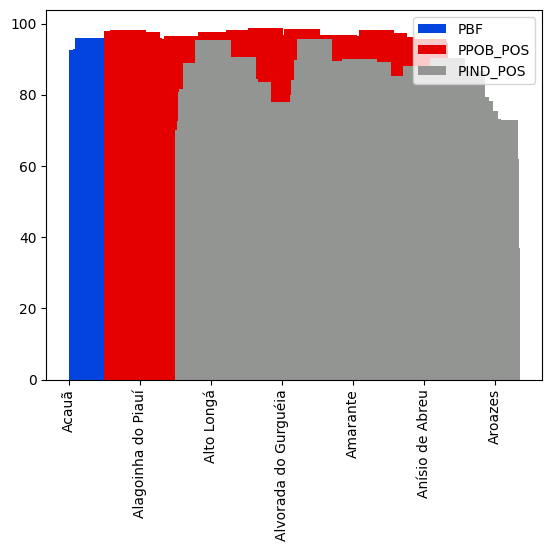

In [296]:
# Initialise a figure. subplots() with no args gives one plot.
fig, ax = plt.subplots()
width = 100
municipios = adm_data_2017['NOME']
x = np.arange(len(municipios))

ax.bar(x - 3*width/2, adm_data_2017['PBF'], width, label='PBF', color='#0343df')
ax.bar(x - width/2, adm_data_2017['PPOB_POS'], width, label='PPOB_POS', color='#e50000')
#ax.bar(x + width/2, adm_data_2017['liberal'], width, label='Liberal', color='#ffff14')
ax.bar(x + 3*width/2, adm_data_2017['PIND_POS'], width, label='PIND_POS', color='#929591')

#ax.set_ylabel('Seats')
#ax.set_title('UK election results')
#ax.set_xticks(x)    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(municipios.astype(str), rotation='vertical')
ax.legend()

# Ask Matplotlib to show the plot
plt.show()



## Água

### Indicadores de Qualidade da Agua

In [297]:
qual_agua = pd.read_csv('/work/Data/indicadores_de_qualidade_da_agua.csv')

qual_agua

Unnamed: 0          CDESTACAO SGUF ENTIDADE       CORPODAGUA   LATITUDE  \
0              0           88045000   RS    FEPAM      Lagoa Mirim -33.499316   
1              1  88070000 ou GER68   RS    FEPAM   Arroio Del Rey -33.111140   
2              2           88150800   RS    FEPAM  Lagoa Mangueira -32.937473   
3              3           88316000   RS    FEPAM      Lagoa Mirim -32.640221   
4              4  88300500 ou GER61   RS    FEPAM     Rio Jaquarão -32.571430   
...          ...                ...  ...      ...              ...        ...   
3363        3363             MRT-01   CE   COGERH      Martinópole  -3.239127   
3364        3364             TUC-01   CE   COGERH        Tucunduba  -3.182074   
3365        3365             GAN-01   CE   COGERH         Gangorra  -3.170566   
3366        3366             DI2-01   CE   COGERH    Diamantino II  -3.154950   
3367        3367             ITA-01   CE   COGERH           Itaúna  -3.154271   

      LONGITUDE   MIN_2019   MIN_2020   MIN_2021   MED_2019   MED_2020  \
0    -53.432618  77.927723        NaN        NaN  81.201838        NaN   
1    -53.029110  51.543172        NaN        NaN  63.339936        NaN   
2    -52.693726  71.554873        NaN        NaN  73.236911        NaN   
3    -53.149368  72.920613        NaN        NaN  76.345623        NaN   
4    -53.367070  58.152945        NaN        NaN  64.180034        NaN   
...         ...        ...        ...        ...        ...        ...   
3363 -40.615051  76.308157  76.180108  81.646594  81.087824  83.223868   
3364 -40.449379  76.829506  77.175083  83.368772  84.483202  86.245055   
3365 -40.864792  78.301215  78.220457  81.463733  86.884502  87.701505   
3366 -40.363972  83.093592  83.833587  86.329544  85.917649  88.215524   
3367 -41.167488  84.765744  78.920305  78.920305  88.534082  87.254493   

       MED_2021   MAX_2019   MAX_2020   MAX_2021  
0           NaN  83.319385        NaN        NaN  
1           NaN  71.252447        NaN        NaN  
2           NaN  74.388753        NaN        NaN  
3           NaN  80.652583        NaN        NaN  
4           NaN  72.805435        NaN        NaN  
...         ...        ...        ...        ...  
3363  86.230660  86.442504  88.652841  89.071081  
3364  89.013832  88.549105  89.570863  93.143184  
3365  89.208336  91.142523  92.334734  93.840061  
3366  89.800519  88.914002  93.654403  93.654403  
3367  89.286699  91.031295  91.078043  93.679062  

[3368 rows x 16 columns]

In [298]:
# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores

for linha in renda_minima_df:
    if linha['codigo_ibge'] == 
mask = atlas['Código'].isin(codigos_ibge)
atlas_filtrado = atlas[mask] 

atlas_filtrado


SyntaxError: invalid syntax (1621166365.py, line 4)

### Atlas irrigação

O cultivo do cajueiro é realizado com sucesso quando as chuvas anuais situam-se nos limites entre 800mm a 1500mm, distribuídas em cinco a sete meses e período seco de cinco a seis meses, coincidindo com as fases de floração e frutificação. Contudo, cultivos bem sucedidos têm sido observados em regiões onde as chuvas alcançam 4000mm e estação seca de quatro a sete meses, nem sempre bem distribuída. Em regiões com chuvas inferiores a 600mm, o cajueiro tem respondido muito bem à irrigação.

Fonte: https://www.embrapa.br/agencia-de-informacao-tecnologica/cultivos/caju

In [ ]:
atlas = pd.read_csv('/work/Data/Atlas Irrigacao - Area Atual e Potencial.csv', sep=';')

atlas

NameError: name 'pd' is not defined

A Avaliação Ambiental Integrada - AAI e a Avaliação Ambiental Estratégica - AAE são mecanismos para avaliar os impactos ambientais de um conjunto de empreendimentos em uma determinada bacia hidrográfica.

In [ ]:
municipios = unnormalized_df[unnormalized_df['cluster'] == '0']

codigos_ibge = municipios.codigo_ibge

Verificar municipios de producao de caju como é o potencial hidrico deles.

In [ ]:
# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
mask = atlas['Código'].isin(codigos_ibge)
atlas_filtrado = atlas[mask] 

atlas_filtrado

Código                   Município  UF  Arroz Inundado  Café  \
465   2100907                    Araioses  MA             0.0   0.0   
667   2200053                       Acauã  PI             0.0   0.0   
670   2200251          Alagoinha do Piauí  PI             0.0   0.0   
672   2200301                  Alto Longá  PI             0.0   0.0   
674   2200459        Alvorada do Gurguéia  PI             0.0   0.0   
...       ...                         ...  ..             ...   ...   
3030  3166956       Serranópolis de Minas  MG             0.0   6.0   
3076  3170651  Vargem Grande do Rio Pardo  MG             0.0   0.0   
3080  3170909                 Varzelândia  MG             0.0   0.0   
3082  3171030                 Verdelândia  MG             0.0   0.0   
3090  3171600              Virgem da Lapa  MG             0.0   0.0   

      Cana-de-Açúcar Irrigada  \
465                       0.0   
667                       0.0   
670                       0.0   
672                       0.0   
674                       0.0   
...                       ...   
3030                      0.0   
3076                      0.0   
3080                      0.0   
3082                      0.0   
3090                      0.0   

      Outras Culturas em Pivôs Centrais (exceto arroz, café e cana)  \
465                                               0.000               
667                                               0.000               
670                                               0.000               
672                                               0.000               
674                                             149.000               
...                                                 ...               
3030                                              0.000               
3076                                             91.000               
3080                                              0.000               
3082                                              1.279               
3090                                              0.000               

      Pivôs Centrais - Total (considerando sobreposição com arroz, café e cana)  \
465                                               0.000                           
667                                               0.000                           
670                                               0.000                           
672                                               0.000                           
674                                             149.000                           
...                                                 ...                           
3030                                              0.000                           
3076                                             91.000                           
3080                                              0.000                           
3082                                              1.279                           
3090                                              0.000                           

      Outras culturas e sistemas  Área Total Irrigada  \
465                       56.000               56.000   
667                       96.000               96.000   
670                        0.000                0.000   
672                      189.000              189.000   
674                      310.000              459.000   
...                          ...                  ...   
3030                     193.000              199.000   
3076                     262.000              353.000   
3080                     197.000              197.000   
3082                       3.543                4.823   
3090                     226.000              226.000   

      Cana-de-Açúcar Fertirrigada  Área Total (Irrigada e Fertirrigada)  \
465                           0.0                                56.000   
667                           0.0                                96.000 

In [ ]:
atlas_filtrado['AAI - Potencial Total']

465     829.000
667       0.000
670       1.241
672       1.009
674       2.489
         ...   
3030    580.000
3076      1.107
3080    400.000
3082    295.000
3090      6.692
Name: AAI - Potencial Total, Length: 907, dtype: float64

array([[<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >]], dtype=object)

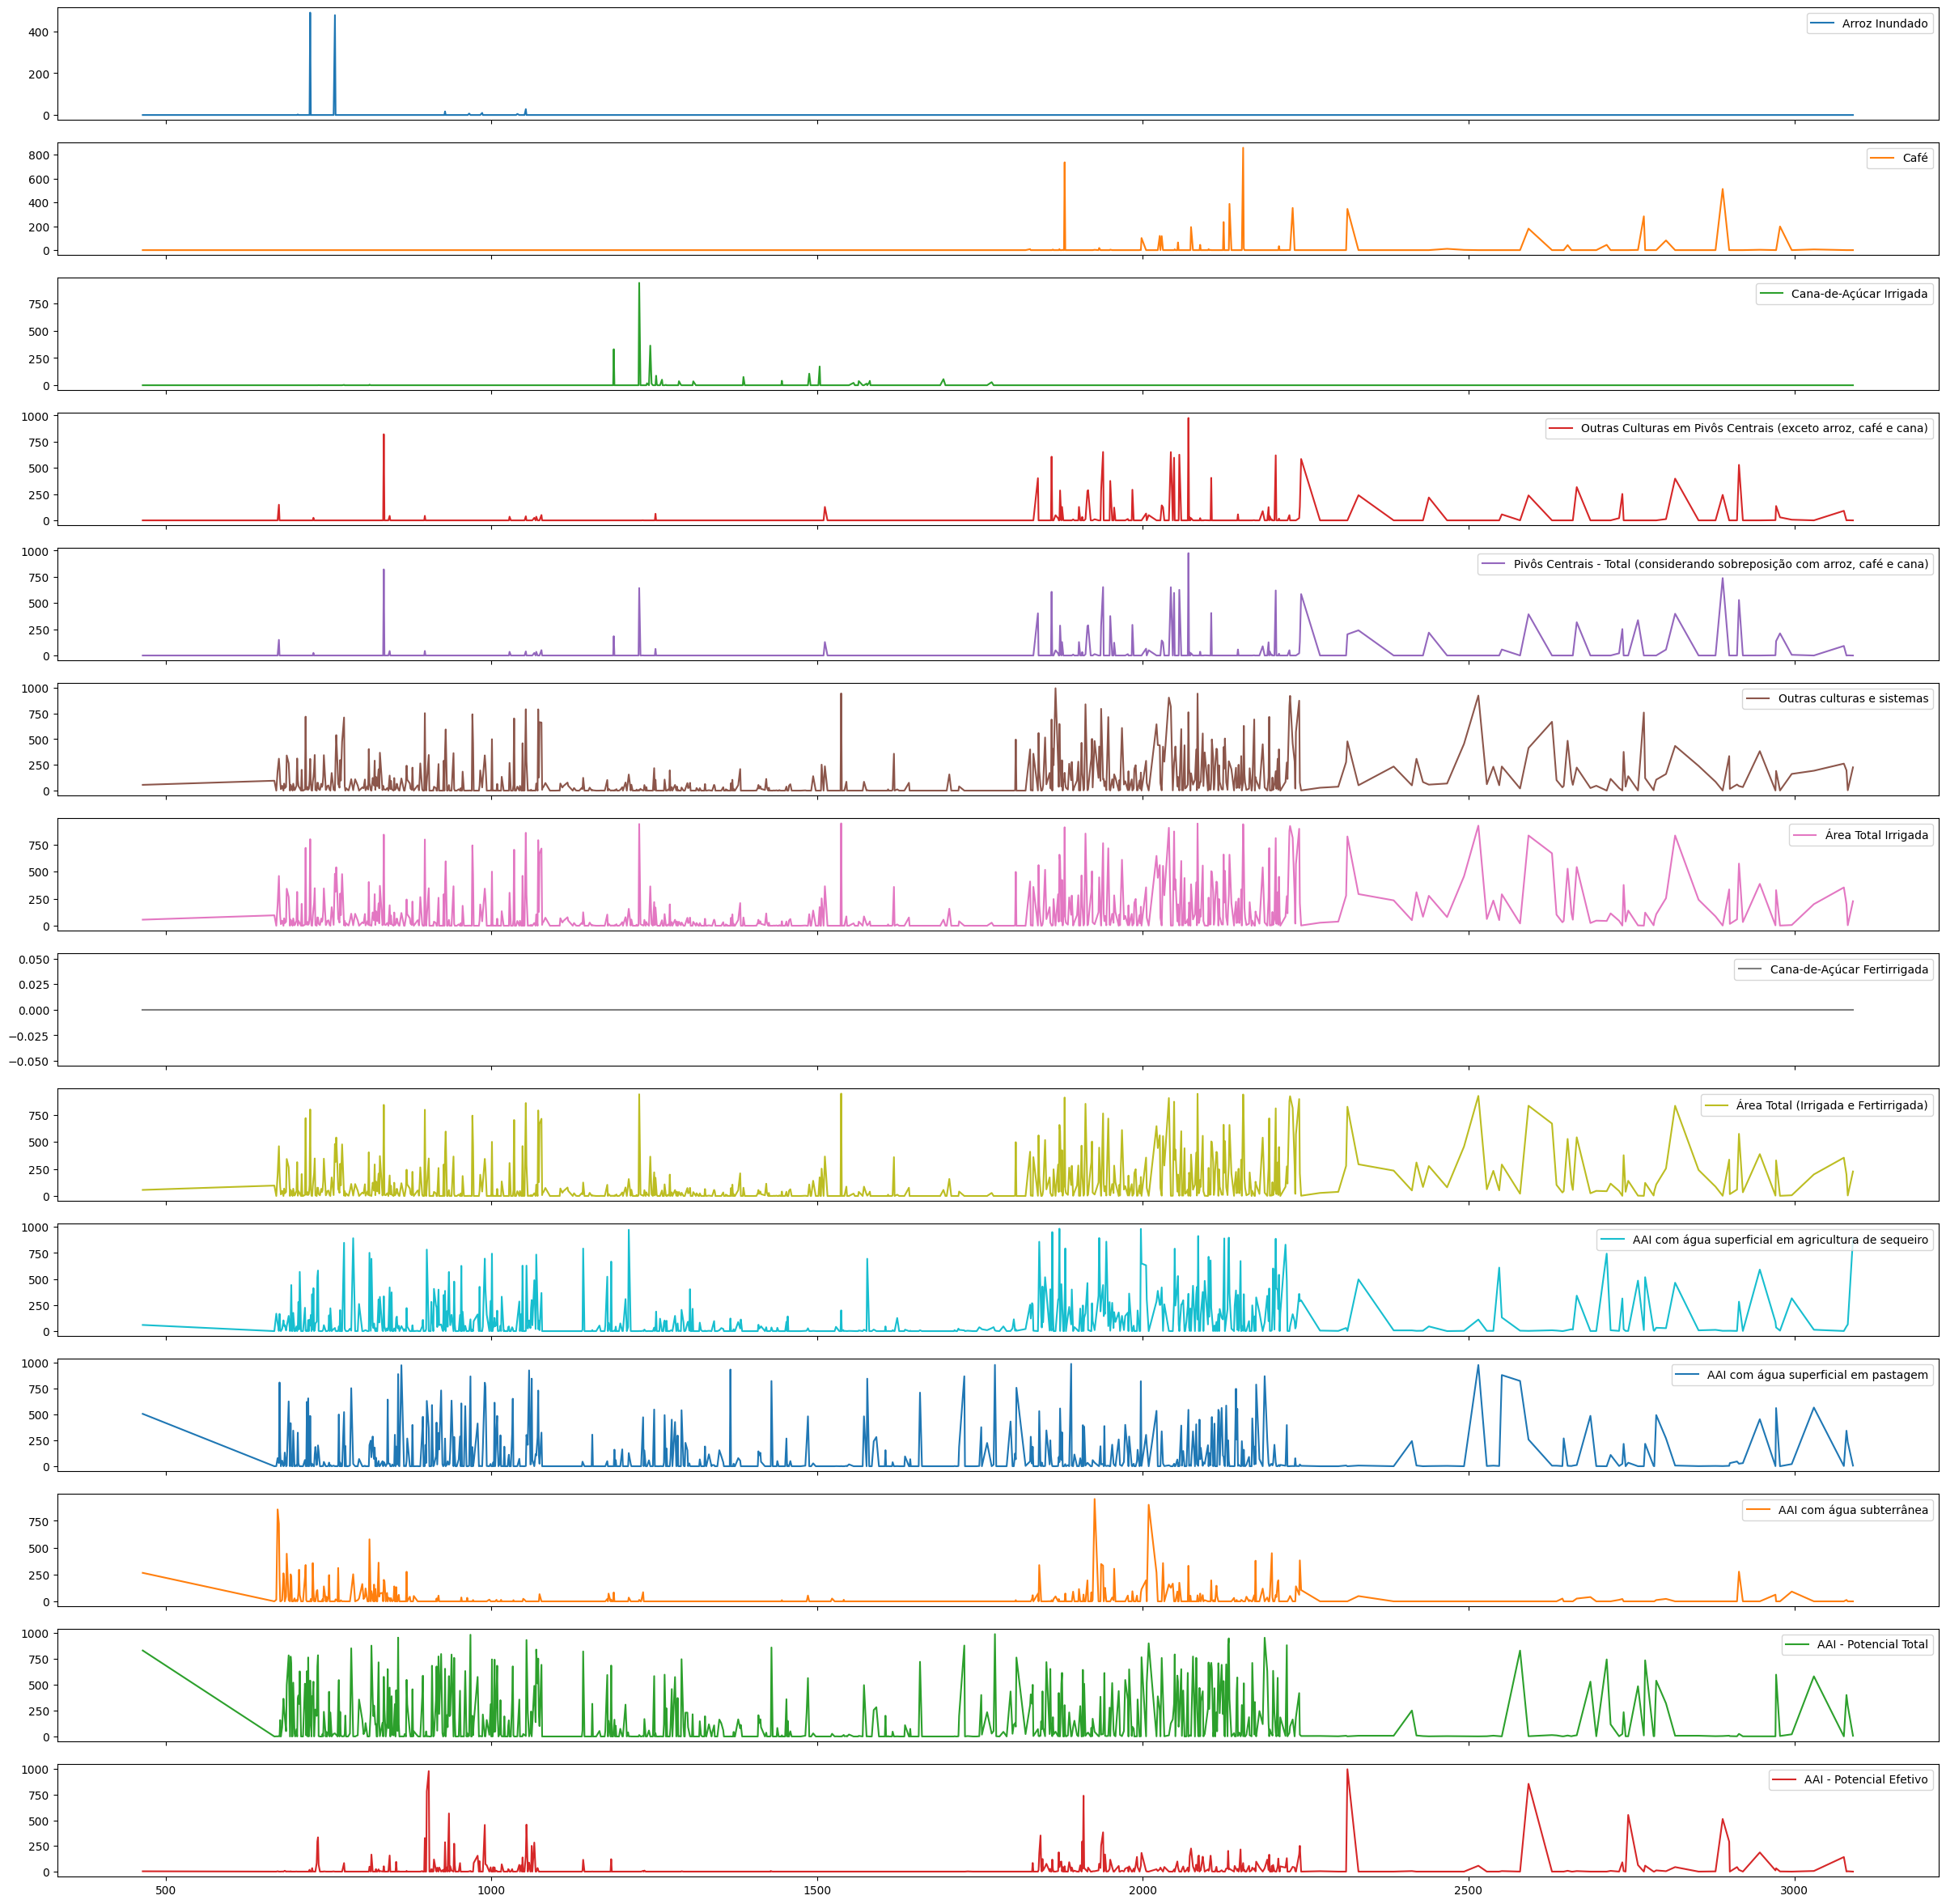

In [ ]:
atlas_filtrado.drop(columns=['Código']).plot(subplots=True, layout=(14, 1), figsize=(30, 30))

## QEdu

In [ ]:
QEdu_2019 = pd.read_csv("./Data/QEdu_2019.csv", sep = ';')

QEdu_2019

COD Municipio  \
0                                               2100477   
1                                               2611804   
2                                               2914000   
3                                               2905800   
4                                               2101707   
...                                                 ...   
1790                                            2200400   
1791                                            2604007   
1792                                            2931905   
1793                                            2930204   
1794  Contagem de escolas conforme rede e escolas co...   

                      Cidade  COD UF   UF Total de escolas federais  \
0     Alto Alegre do Pindaré    21.0   MA                       NaN   
1                   Ribeirão    26.0   PE                       NaN   
2                      Ipirá    29.0   BA                       NaN   
3                     Camamu    29.0   BA                       NaN   
4               Barreirinhas    21.0   MA                       1,0   
...                      ...     ...  ...                       ...   
1790                   Altos    22.0   PI                       NaN   
1791                 Carpina    26.0   PE                       NaN   
1792                  Tucano    29.0   BA                       NaN   
1793                Sento Sé    29.0   BA                       NaN   
1794                     NaN     NaN  NaN                       NaN   

     Total de escolas estaduais Total de escolas municipais  \
0                           8,0                        55,0   
1                           3,0                        32,0   
2                           4,0                        56,0   
3                           1,0                        81,0   
4                           5,0                       140,0   
...                         ...                         ...   
1790                        8,0                        54,0   
1791                        9,0                        22,0   
1792                        4,0                        56,0   
1793                        2,0                        62,0   
1794                        NaN                         NaN   

     Total de escolas privadas  Total de escolas sem creche  \
0                          1,0                         20.0   
1                         16,0                         10.0   
2                          9,0                         55.0   
3                          4,0                         61.0   
4                          5,0                        148.0   
...                        ...                          ...   
1790                       5,0                         49.0   
1791                      36,0                         23.0   
1792                       7,0                         20.0   
1793                       3,0                         61.0   
1794                       NaN                          NaN   

     Total de escolas com creche  ...  \
0                           44,0  ...   
1                           41,0  ...   
2                           14,0  ...   
3                           25,0  ...   
4                            3,0  ...   
...                          ...  ...   
1790                        18,0  ...   
1791                        44,0  ...   
1792                        47,0  ...   
1793                         6,0  ...   
1794                         NaN  ...   

     Total de docentes em Ensino Fundamental - Projovem Urbano  \
0                                                   NaN          
1                                                   NaN          
2                                                   NaN          
3                                                   NaN          
4                                                   NaN          
...                                                 ...          
1790       

In [ ]:
QEdu_2019.columns

Index(['COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
       'Total de escolas estaduais', 'Total de escolas municipais',
       'Total de escolas privadas', 'Total de escolas sem creche',
       'Total de escolas com creche',
       'Escolas que não funcionam em prédio escolar',
       'Escolas que funcionam em prédio escolar',
       'Total de escolas que não funcionam em unidade de atendimento socio educativo',
       'Total de escolas que funcionam em unidade de atendimento socio educativo',
       'Total de escolas que não funcionam em unidade prisional',
       'Total de escolas que funcionam em unidade prisional',
       'Total de escolas que não funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que não funcionam em salas de outra escola',
       'Total de escolas que funcionam em salas de outra escola',
       'Total de escolas que não funcionam em ou

In [ ]:
colunas_para_manter = [
                        'COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
                        'Total de escolas estaduais', 'Total de escolas municipais',
                        'Total de escolas privadas', 'Total de escolas sem creche',
                        'Total de escolas com creche',
                        'Escolas que funcionam em prédio escolar',
                        'Total de escolas que funcionam em unidade de atendimento socio educativo',
                        'Total de escolas que funcionam em unidade prisional',
                        'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
                        'Total de escolas que funcionam em salas de outra escola',
                        'Total de escolas que funcionam em outros locais',
                        'Total de escolas que não tem abastecimento de água da rede pública',
                        'Total de escolas que não possuem abastecimento de água',
                        'Total de escolas que não possuem energia elétrica da rede pública',
                        'Total de escolas que não possuem energia elétrica', 
                        'Total de matrículas', 'Total de docentes',
                        'Total de docentes em Ensino Fundamental - Anos Iniciais',
                        'Total de docentes em Ensino Fundamental - Anos Finais',
                        'Total de docentes em Ensino Médio',
                        'Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental)',
                        'Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio)',
                        ]



In [ ]:
# QEdu_2019.rename(columns={'COD Municipio': 'codigo_ibge'})

In [ ]:
municipios = unnormalized_reduced_df[unnormalized_reduced_df['cluster'] == 0]
municipios

NameError: name 'unnormalized_reduced_df' is not defined

In [ ]:
codigos_ibge = municipios.codigo_ibge

# Converter a coluna para numérica (int64) e tratar erros como NaN
QEdu_2019['COD Municipio'] = pd.to_numeric(QEdu_2019['COD Municipio'], errors='coerce')

# Remover as linhas onde a coluna não pôde ser convertida para numérica (NaN)
QEdu_2019 = QEdu_2019.dropna(subset=['COD Municipio'])

# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
QEdu_2019['COD Municipio'] = QEdu_2019['COD Municipio'].astype('int64')
mask = QEdu_2019['COD Municipio'].isin(codigos_ibge)
QEdu_2019_filtrado = QEdu_2019[mask] 

QEdu_2019_filtrado = QEdu_2019_filtrado[colunas_para_manter]

# Função para trocar as vírgulas por pontos para que os dados sejam numéricos
def remover_virgulas_e_converter(valor):
    if isinstance(valor, str):
        try:
            return float(valor.replace(',', '.'))
        except ValueError:
            return valor  # Retorna o valor original em caso de erro
    else:
        return valor  # Retorna o valor original se não for uma string

# Aplicar a função às colunas selecionadas
colunas_total = [col for col in QEdu_2019_filtrado.columns if col.startswith("Total")]
QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(remover_virgulas_e_converter)


# QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(converter_colunas_para_numeros)

# Considerar falores nulos como 0
QEdu_2019_filtrado = QEdu_2019_filtrado.fillna(0)


QEdu_2019_filtrado

/tmp/ipykernel_41/3867670128.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COD Municipio           Cidade  COD UF  UF  Total de escolas federais  \
6           2602803           Buíque    26.0  PE                        0.0   
12          2314102  Viçosa do Ceará    23.0  CE                        0.0   
15          2925907        Quijingue    29.0  BA                        0.0   
19          2304707           Granja    23.0  CE                        0.0   
21          2302404       Boa Viagem    23.0  CE                        1.0   
...             ...              ...     ...  ..                        ...   
1757        2305902         Ipueiras    23.0  CE                        0.0   
1763        2201200           Barras    22.0  PI                        0.0   
1768        2909901           Curaçá    29.0  BA                        0.0   
1785        2917003           Itiúba    29.0  BA                        0.0   
1793        2930204         Sento Sé    29.0  BA                        0.0   

      Total de escolas estaduais  Total de escolas municipais  \
6                           10.0                         38.0   
12                           4.0                         70.0   
15                           2.0                         49.0   
19                           5.0                         56.0   
21                           2.0                         71.0   
...                          ...                          ...   
1757                         4.0                         48.0   
1763                         9.0                         43.0   
1768                         4.0                         53.0   
1785                         2.0                         59.0   
1793                         2.0                         62.0   

      Total de escolas privadas  Total de escolas sem creche  \
6                           3.0                         47.0   
12                          3.0                         39.0   
15                          1.0                         42.0   
19                          3.0                         23.0   
21                          2.0                         28.0   
...                         ...                          ...   
1757                        2.0                         29.0   
1763                        4.0                         19.0   
1768                        1.0                         54.0   
1785                        4.0                         36.0   
1793                        3.0                         61.0   

      Total de escolas com creche  ...  \
6                             4.0  ...   
12                           38.0  ...   
15                           10.0  ...   
19                           41.0  ...   
21                           48.0  ...   
...                           ...  ...   
1757                         25.0  ...   
1763                         37.0  ...   
1768                          4.0  ...   
1785                         29.0  ...   
1793                          6.0  ...   

      Total de escolas que não possuem abastecimento de água  \
6                                                   4.0        
12                                                  0.0        
15                                                  0.0        
19                                                  0.0        
21                                                  1.0        
...                                                 ...        
1757                                                0.0        
1763                                                0.0        
1768                                                0.0        
1785                                                1.0        
1793                                                0.0        

      Total de escolas que não possuem energia elétrica da rede pública  \
6                                                   1.0                   
12                                                  0.0                   
15      

Transformar valores absolutos em taxas

In [ ]:
QEdu_2019_filtrado['Total escolas'] = (QEdu_2019_filtrado['Total de escolas federais'] + 
                                       QEdu_2019_filtrado['Total de escolas estaduais'] + 
                                       QEdu_2019_filtrado['Total de escolas municipais']+
                                       QEdu_2019_filtrado['Total de escolas privadas'])

In [ ]:
# Encontre as colunas que têm "escola" em seus nomes
colunas_escola = [coluna for coluna in QEdu_2019_filtrado.columns if 'escola' in coluna.lower()]

# Divida essas colunas pelo valor da coluna "Total de Escolas"
QEdu_2019_taxa = QEdu_2019_filtrado[['Cidade']].copy()  
for coluna_escola in colunas_escola:
    taxa_coluna = QEdu_2019_filtrado[coluna_escola] / QEdu_2019_filtrado['Total escolas']
    QEdu_2019_taxa[coluna_escola] = taxa_coluna  # Adicione as colunas de taxa calculadas

QEdu_2019_taxa.drop(columns=['Total escolas'], inplace=True)
QEdu_2019_taxa

Cidade  Total de escolas federais  Total de escolas estaduais  \
6              Buíque                   0.000000                    0.196078   
12    Viçosa do Ceará                   0.000000                    0.051948   
15          Quijingue                   0.000000                    0.038462   
19             Granja                   0.000000                    0.078125   
21         Boa Viagem                   0.013158                    0.026316   
...               ...                        ...                         ...   
1757         Ipueiras                   0.000000                    0.074074   
1763           Barras                   0.000000                    0.160714   
1768           Curaçá                   0.000000                    0.068966   
1785           Itiúba                   0.000000                    0.030769   
1793         Sento Sé                   0.000000                    0.029851   

      Total de escolas municipais  Total de escolas privadas  \
6                        0.745098                   0.058824   
12                       0.909091                   0.038961   
15                       0.942308                   0.019231   
19                       0.875000                   0.046875   
21                       0.934211                   0.026316   
...                           ...                        ...   
1757                     0.888889                   0.037037   
1763                     0.767857                   0.071429   
1768                     0.913793                   0.017241   
1785                     0.907692                   0.061538   
1793                     0.925373                   0.044776   

      Total de escolas sem creche  Total de escolas com creche  \
6                        0.921569                     0.078431   
12                       0.506494                     0.493506   
15                       0.807692                     0.192308   
19                       0.359375                     0.640625   
21                       0.368421                     0.631579   
...                           ...                          ...   
1757                     0.537037                     0.462963   
1763                     0.339286                     0.660714   
1768                     0.931034                     0.068966   
1785                     0.553846                     0.446154   
1793                     0.910448                     0.089552   

      Escolas que funcionam em prédio escolar  \
6                                    1.000000   
12                                   1.000000   
15                                   0.980769   
19                                   1.000000   
21                                   1.000000   
...                                       ...   
1757                                 1.000000   
1763                                 1.000000   
1768                                 0.948276   
1785                                 0.969231   
1793                                 0.955224   

      Total de escolas que funcionam em unidade de atendimento socio educativo  \
6                                                   0.0                          
12                                                  0.0                          
15                                                  0.0                          
19                                                  0.0                          
21                                                  0.0                          
...                                                 ...                          
1757                                                0.0                          
1763                                                0.0                          
1768                                                0.0                          
1785                                                0.0                          
1

array([[<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >],
       [<AxesSubplot: >]], dtype=object)

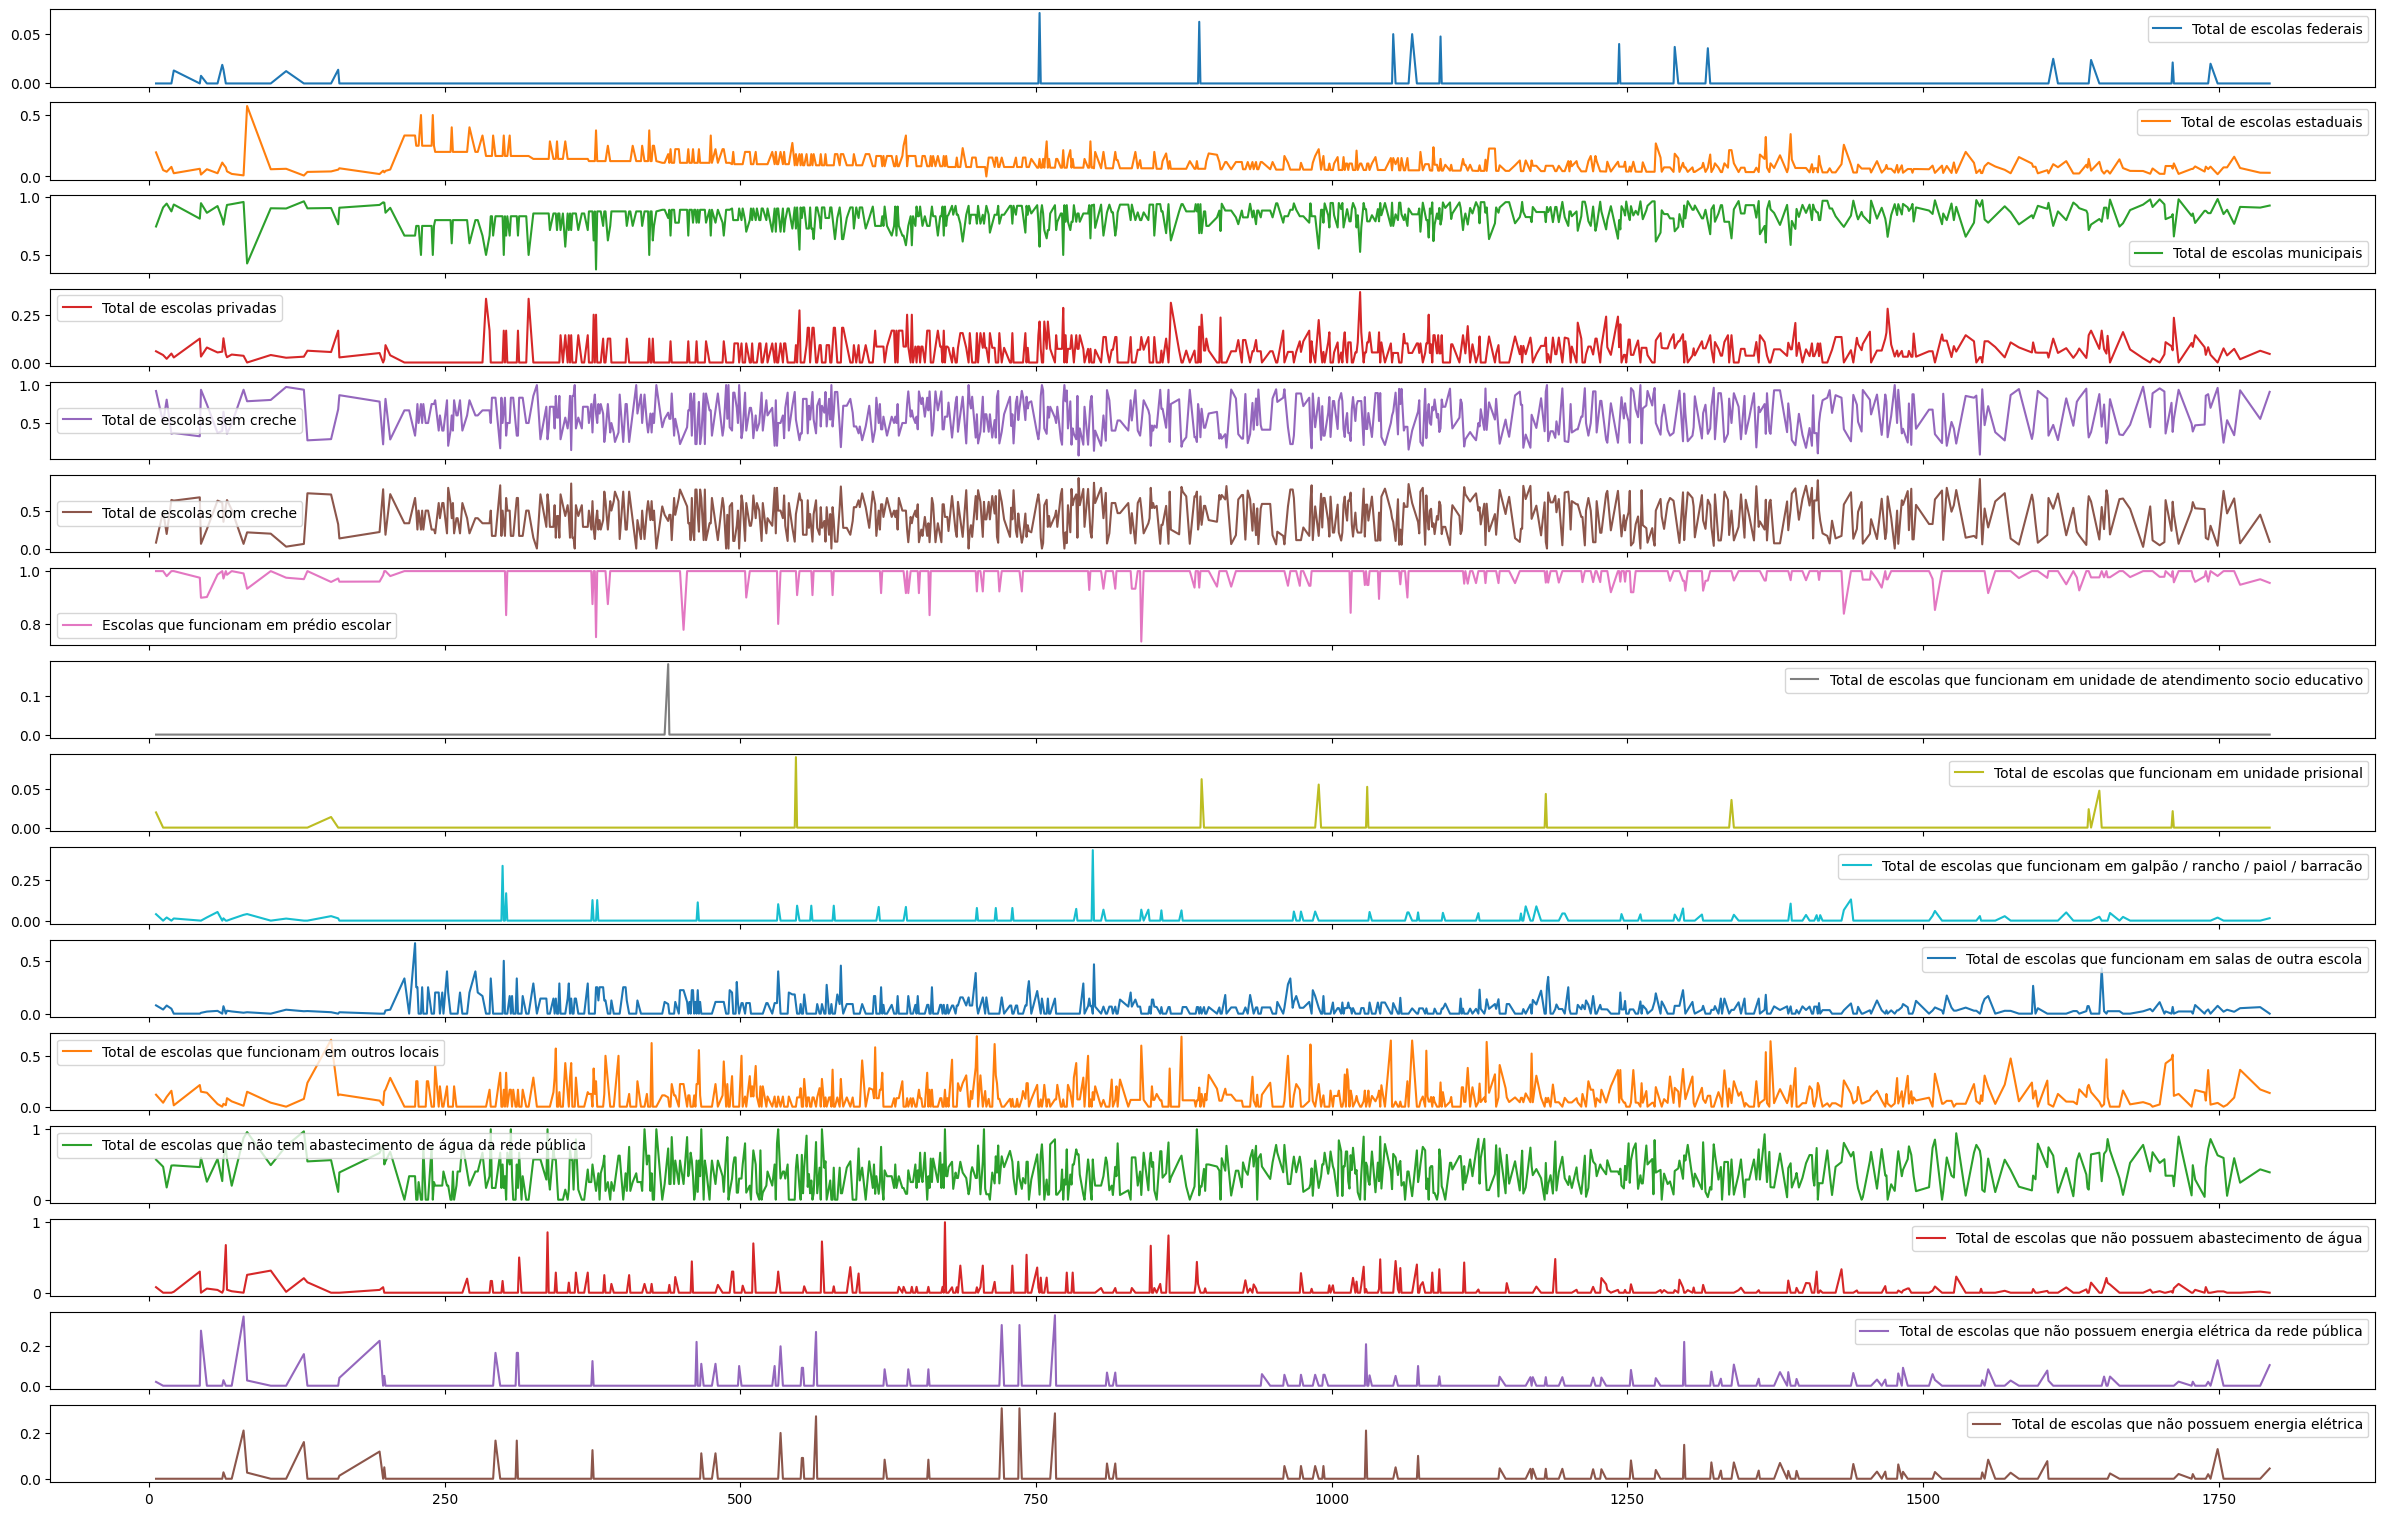

In [ ]:
QEdu_2019_taxa.plot(subplots=True, layout=(25, 1), figsize=(30, 30))

In [ ]:
# Calcule a média 
media_escolas_predio_escolar = QEdu_2019_taxa['Escolas que funcionam em prédio escolar'].mean()
media_escolas_agua = QEdu_2019_taxa['Total de escolas que não possuem abastecimento de água'].mean()
media_escolas_energia = QEdu_2019_taxa['Total de escolas que não possuem energia elétrica'].mean()
print(f'Médias: escolas em prédio escolar: {media_escolas_predio_escolar}, abastecimente de água: {media_escolas_agua}, energia: {media_escolas_energia}')
# Ideia: Filtrar dados baseado na média
QEdu_2019_piores_indices = QEdu_2019_taxa[QEdu_2019_taxa['Escolas que funcionam em prédio escolar'] <= media_escolas_predio_escolar]
QEdu_2019_piores_indices = QEdu_2019_piores_indices[QEdu_2019_taxa['Total de escolas que não possuem abastecimento de água'] >= media_escolas_energia/4]
QEdu_2019_piores_indices = QEdu_2019_piores_indices[QEdu_2019_taxa['Total de escolas que não possuem energia elétrica'] >= media_escolas_agua/4]

QEdu_2019_piores_indices

Médias: escolas em prédio escolar: 0.9912073880904387, abastecimente de água: 0.034740016726521085, energia: 0.006494283340463412
/tmp/ipykernel_41/464807840.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_41/464807840.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Cidade  Total de escolas federais  \
63                   Pedro II                   0.014085   
83       Carnaubeira da Penha                   0.000000   
131   Campo Alegre de Lourdes                   0.000000   
195                   Remanso                   0.000000   
817                      Patu                   0.000000   
1221                  Serrita                   0.000000   
1253                    Itagi                   0.000000   
1510                   Manari                   0.000000   
1605             Encruzilhada                   0.000000   
1658          Pedro Alexandre                   0.000000   
1749        Itaguaçu da Bahia                   0.000000   

      Total de escolas estaduais  Total de escolas municipais  \
63                      0.098592                     0.760563   
83                      0.573333                     0.426667   
131                     0.007634                     0.961832   
195                     0.019802                     0.930693   
817                     0.200000                     0.666667   
1221                    0.041667                     0.916667   
1253                    0.040000                     0.920000   
1510                    0.029412                     0.970588   
1605                    0.051282                     0.897436   
1658                    0.023256                     0.976744   
1749                    0.018519                     0.981481   

      Total de escolas privadas  Total de escolas sem creche  \
63                     0.126761                     0.647887   
83                     0.000000                     0.786667   
131                    0.030534                     0.938931   
195                    0.049505                     0.782178   
817                    0.133333                     0.400000   
1221                   0.041667                     0.916667   
1253                   0.040000                     0.960000   
1510                   0.000000                     0.352941   
1605                   0.051282                     0.820513   
1658                   0.000000                     0.813953   
1749                   0.000000                     0.962963   

      Total de escolas com creche  Escolas que funcionam em prédio escolar  \
63                       0.352113                                 0.971831   
83                       0.213333                                 0.933333   
131                      0.061069                                 0.969466   
195                      0.217822                                 0.960396   
817                      0.600000                                 0.933333   
1221                     0.083333                                 0.958333   
1253                     0.040000                                 0.920000   
1510                     0.647059                                 0.852941   
1605                     0.179487                                 0.974359   
1658                     0.186047                                 0.976744   
1749                     0.037037                                 0.981481   

      Total de escolas que funcionam em unidade de atendimento socio educativo  \
63                                                  0.0                          
83                                                  0.0                          
131                                                 0.0                          
195                                                 0.0                          
817                                                 0.0                          
1221                                                0.0                          
1253                                                0.0                          
1510                                                0.0                          
1605                                                0.0                      

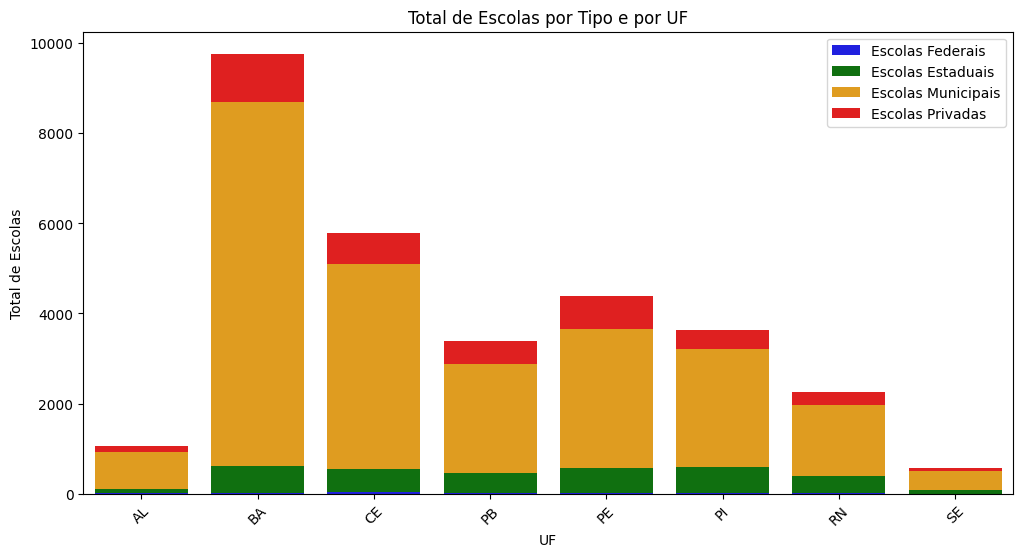

In [ ]:
# dados = QEdu_2019_somas[['UF', 'Total de escolas federais', 'Total de escolas estaduais', 'Total de escolas municipais', 'Total de escolas privadas']]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x='UF', y='Total de escolas federais', data=dados, label='Escolas Federais', color='blue')
# ax = sns.barplot(x='UF', y='Total de escolas estaduais', data=dados, label='Escolas Estaduais', bottom=dados['Total de escolas federais'], color='green')
# ax = sns.barplot(x='UF', y='Total de escolas municipais', data=dados, label='Escolas Municipais', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'], color='orange')
# ax = sns.barplot(x='UF', y='Total de escolas privadas', data=dados, label='Escolas Privadas', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'] + dados['Total de escolas municipais'], color='red')

# plt.xlabel('UF')
# plt.ylabel('Total de Escolas')
# plt.title('Total de Escolas por Tipo e por UF')
# plt.xticks(rotation=45)
# plt.legend()

# plt.show()

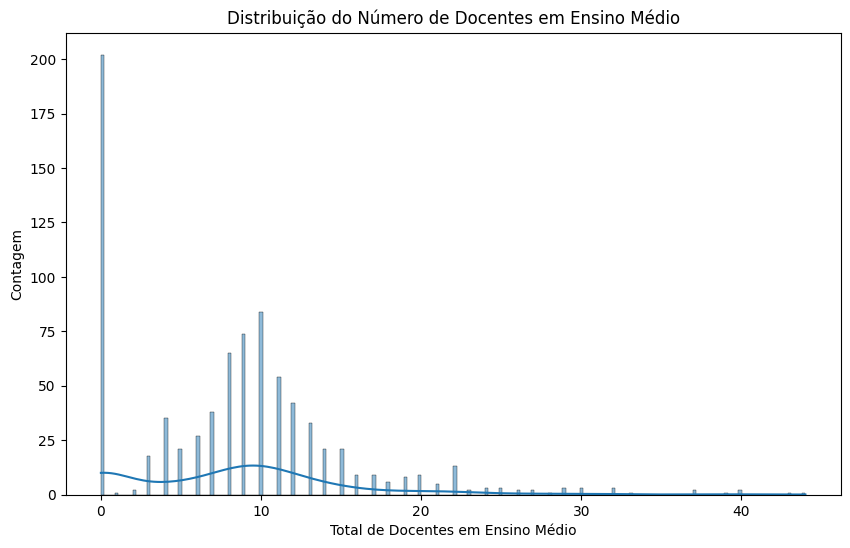

In [ ]:
# Histograma Docentes ensino médio
plt.figure(figsize=(10, 6))
sns.histplot(QEdu_2019_filtrado['Total de docentes em Ensino Médio'], bins=200, kde=True)
plt.xlabel('Total de Docentes em Ensino Médio')
plt.ylabel('Contagem')
plt.title('Distribuição do Número de Docentes em Ensino Médio')

plt.show()

## Análise de viabilidade

### Custos de transporte

In [ ]:
# Carregando o dataset de transporte
original_transportes_df = pd.read_csv('./Data/transport_cost.csv')
transportes_df = original_transportes_df.copy()
transportes_df.drop(columns=['codigo_ibge', 'codigo_uf'], inplace=True)
transportes_df

mask = transportes_df['nome'].isin(unnormalized_df['nome'].values)
unique_cities = transportes_df[mask]['nome'].unique()

# mean_transportation_cost = []
# for city in unique_cities:
#     _df = transportes_df[transportes_df['codigo_ibge'] == city]
#     mean_transportation_cost.append(_df['transportation_cost'].values.mean())

# unnormalized_transport_df = unnormalized_df.copy()
# unnormalized_transport_df['transportation_cost'] = mean_transportation_cost
# unnormalized_transport_df
unique_cities


In [ ]:
unnormalized_transportes_df = pd.merge(unnormalized_df, transportes_df, left_on='codigo_ibge', right_on='codigo_ibge')
unnormalized_transportes_df

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6e046c8-57b3-47c6-bce9-1538a03fcdec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>